<h1>Preprocessing</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

In [4]:
t = Template(texp, '267-02_pdmc_t')

In [5]:
t.remove_gate('raw_auto_boundary', propagate=True)
t.print_population_tree()

root


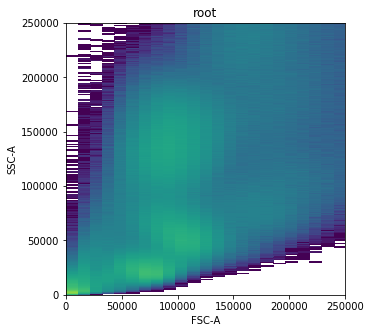

In [6]:
t.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

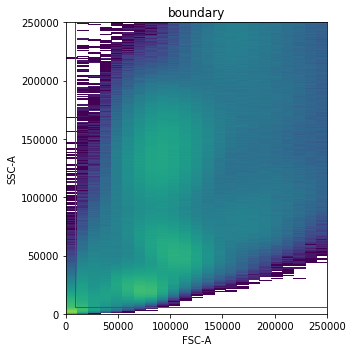

In [7]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             bottom_cutoff=0.05, top_cutoff=0.95)
t.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='border_gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('boundary')

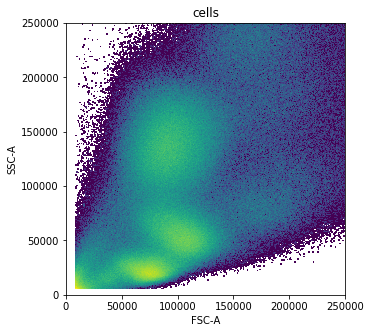

In [8]:
t.plotting.plot_population('cells', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

In [9]:
children = ChildPopulationCollection('geom')
children.add_population('lymphocytes', definition='+')
children.add_population('other cells', definition='-')
filter_ = dict(xmin=5000, xmax=150000, ymin=0, ymax=100000)
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, 
              target=(75000, 25000), conf=0.99, algo='bayesian', k=5,
             rect_filter=filter_)
t.create_gate(gate_name='lymphocyte_gate', 
              parent='cells',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)

True

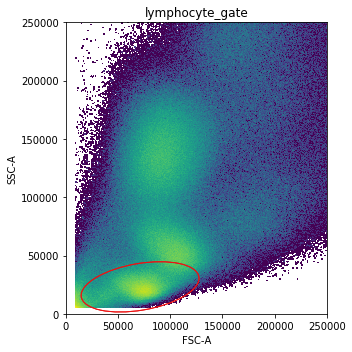

In [10]:
t.apply('lymphocyte_gate')

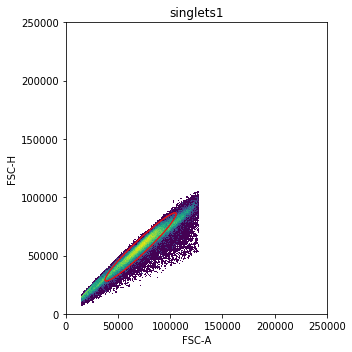

In [11]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
t.create_gate(gate_name='singlets1', 
              parent='lymphocytes',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets1')

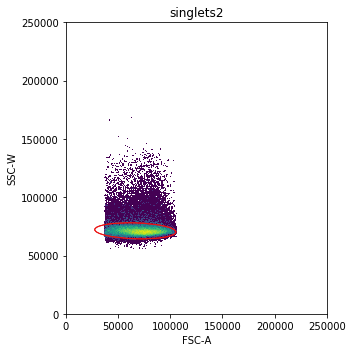

In [12]:
children = ChildPopulationCollection('geom')
children.add_population('singlets2', definition='+')
children.add_population('doublets2', definition='-')
kwargs = dict(x='FSC-A', y='SSC-W', transform_x=None, transform_y=None, target=(75000, 70000),
             conf=0.99)
t.create_gate(gate_name='singlets2', 
              parent='singlets1',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets2')

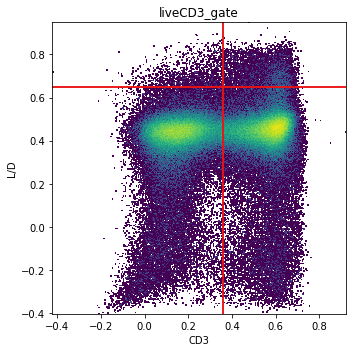

In [13]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('liveCD3', definition='+-')
children.add_population('dead', definition=['--', '-+', '++'])
kwargs = dict(x='CD3', y='L/D', kde_bw=0.05, q=0.95, peak_threshold=0.05)
t.create_gate(gate_name='liveCD3_gate', 
              parent='singlets2',
              class_='DensityThreshold',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('liveCD3_gate')

In [14]:
t.save(overwrite=True)

Saved successfully!


True

In [15]:
t.save_new_template('Preprocessing T Panel')

No existing template named Preprocessing T Panel, creating new template


True

<h2>Applying the preprocessing template to the remaining samples</h2>

In [12]:
def apply_template(sample_id):
    print(f'------------------ {sample_id} ------------------')
    t = Template(texp, sample_id)
    t.load_template('Preprocessing T Panel')
    t.apply_many(apply_all=True, plot_outcome=False)
    print('Gating complete!')
    print('Saving...')
    t.save(overwrite=True)
    print('Sample gated and saved!')

In [13]:
sample_list = [s for s in texp.list_samples() if s != '267-02_pdmc_t']
for sample in sample_list:
    apply_template(sample)

------------------ 142-09_pdmc_t ------------------
Applying boundary...
Applying lymphocyte_gate...
Applying singlets1...
Applying singlets2...
Applying liveCD3_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!
------------------ 165-09_pdmc_t ------------------
Applying boundary...
Applying lymphocyte_gate...
Applying singlets1...
Applying singlets2...
Applying liveCD3_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!
------------------ 175-09_pdmc_t ------------------
Applying boundary...
Applying lymphocyte_gate...
Applying singlets1...
Applying singlets2...
Applying liveCD3_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!
------------------ 209-03_pdmc_t ------------------
Applying boundary...
Applying lymphocyte_gate...
Applying singlets1...
Applying singlets2...
Applying liveCD3_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and sav

<h2>Check Gates</h2>

In [31]:
sample_list = [s for s in texp.list_samples() if s != '267-02_pdmc_t']

In [32]:
def plot_all(sample_id):
    print(f'--------------- {sample_id} ---------------')
    gates = ['boundary', 'lymphocyte_gate', 'singlets1', 'singlets2', 'liveCD3_gate']
    t = Gating(texp, sample_id)
    t.plotting.plot_gate('boundary', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('lymphocyte_gate', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('singlets1', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('singlets2', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('liveCD3_gate', transforms={'x': 'logicle', 'y': 'logicle'})

--------------- 142-09_pdmc_t ---------------


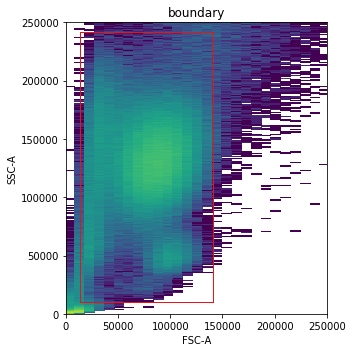

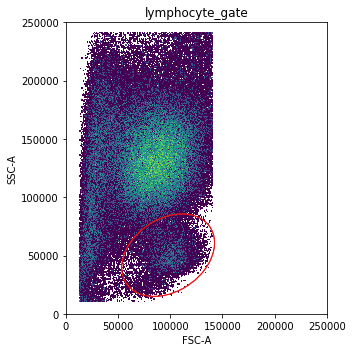

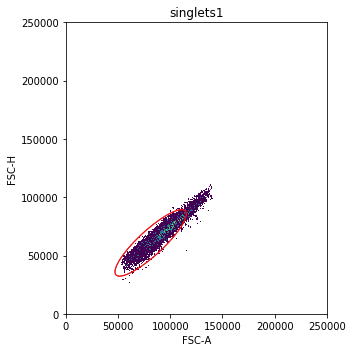

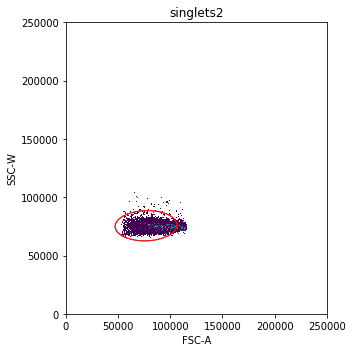

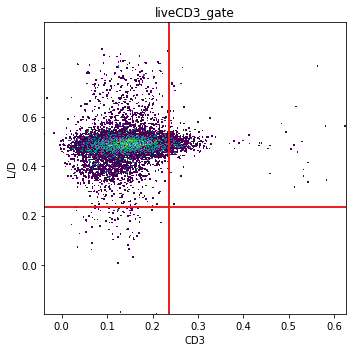

In [50]:
plot_all(sample_list[0])

In [51]:
t = Gating(texp, sample_list[0])

In [52]:
t.remove_gate('lymphocyte_gate', propagate=True)

(['singlets1', 'singlets2', 'liveCD3_gate', 'lymphocyte_gate'],
 ['lymphocytes',
  'singlets1',
  'singlets2',
  'liveCD3',
  'dead',
  'doublets2',
  'doublets1',
  'lymphocytes',
  'other cells',
  'other cells'])

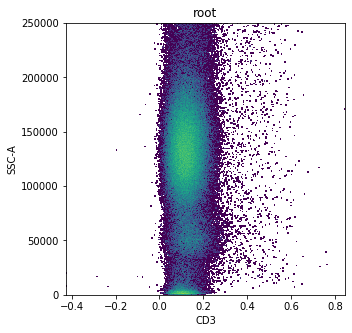

In [53]:
t.plotting.plot_population('root', 'CD3', 'SSC-A', transforms={'x':'logicle', 'y':None})

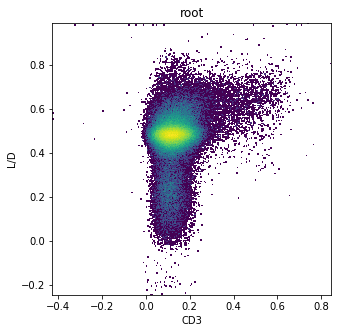

In [54]:
t.plotting.plot_population('root', 'CD3', 'L/D', transforms={'x':'logicle', 'y': 'logicle'})

**Remove 142-09_pdmc_t from analysis**

In [74]:
fg = texp.pull_sample(sample_list[0])

In [73]:
fg.flags = 'invalid'
fg.notes = 'Low cell count;no CD3+ cells'
fg.save()

<FileGroup: FileGroup object>

--------------- 165-09_pdmc_t ---------------


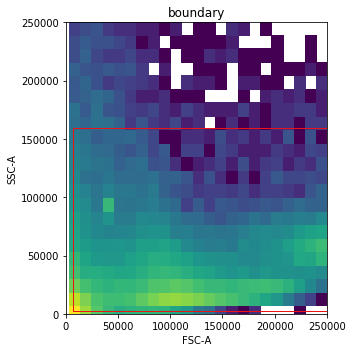

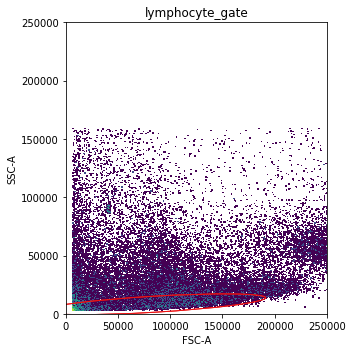

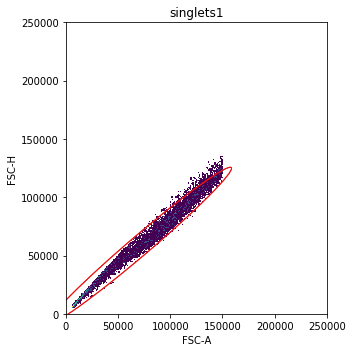

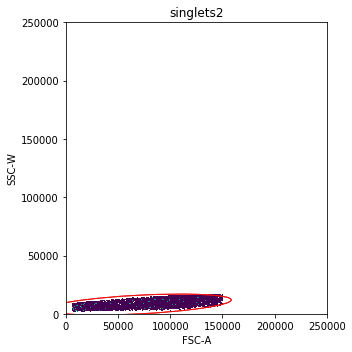

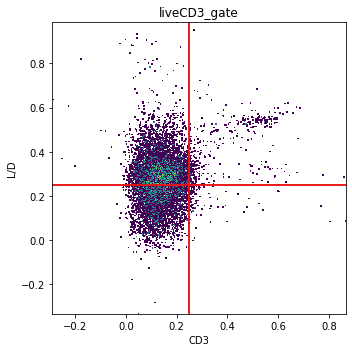

In [55]:
plot_all(sample_list[1])

In [56]:
t = Gating(texp, sample_list[1])

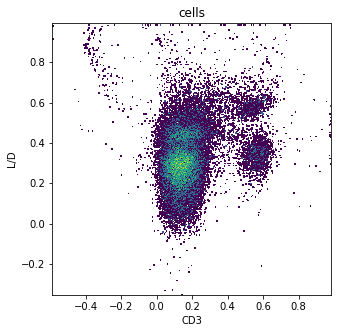

In [57]:
t.plotting.plot_population('cells', 'CD3', 'L/D', transforms={'x':'logicle', 'y': 'logicle'})

In [58]:
t.remove_gate('lymphocyte_gate', propagate=True)

(['singlets1', 'singlets2', 'liveCD3_gate', 'lymphocyte_gate'],
 ['lymphocytes',
  'singlets1',
  'singlets2',
  'liveCD3',
  'dead',
  'doublets2',
  'doublets1',
  'lymphocytes',
  'other cells',
  'other cells'])

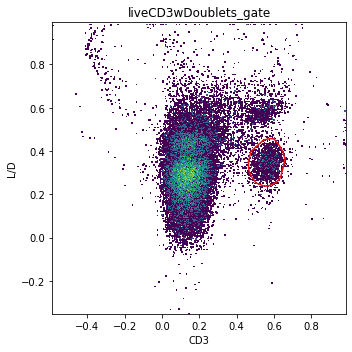

In [59]:
children = ChildPopulationCollection('cluster')
children.add_population('liveCD3_w_doublets', target=(0.6, 0.4), weight=1)
kwargs = dict(x='CD3', y='L/D', min_pop_size=30, frac=0.9, downsample_method='density')
t.create_gate(gate_name='liveCD3wDoublets_gate', 
              parent='cells',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
t.apply('liveCD3wDoublets_gate')

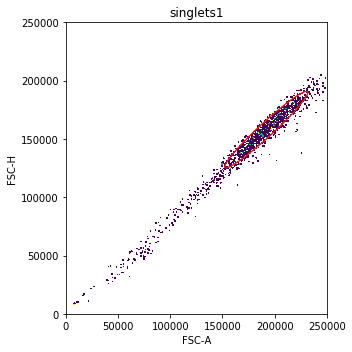

In [60]:
children = ChildPopulationCollection('geom')
children.add_population('liveCD3', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(200000, 150000),
             conf=0.8)
t.create_gate(gate_name='singlets1', 
              parent='liveCD3_w_doublets',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets1')

In [61]:
print(f'Only {len(t.populations["liveCD3"].index)} live CD3+ T cells!')

Only 983 live CD3+ T cells!


In [62]:
t.save(overwrite=True)

Saved successfully!


True

--------------- 175-09_pdmc_t ---------------


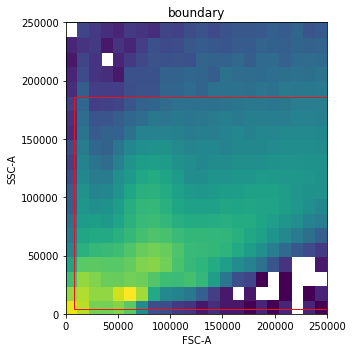

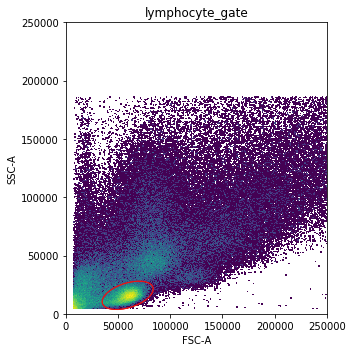

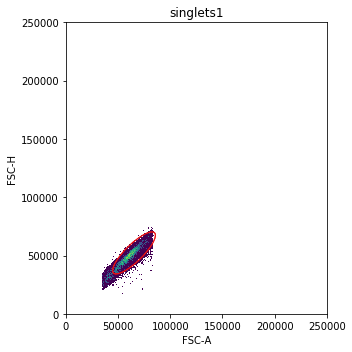

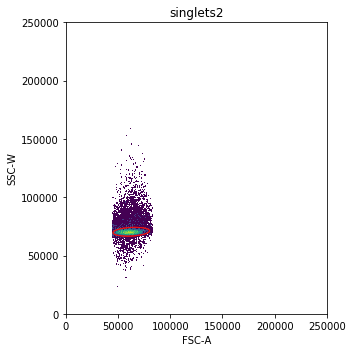

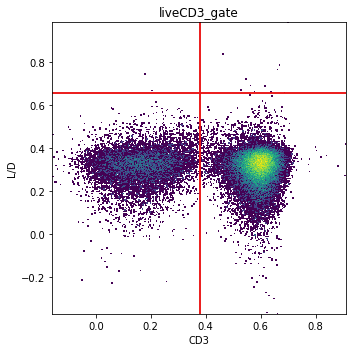

In [63]:
plot_all(sample_list[2])

--------------- 209-03_pdmc_t ---------------


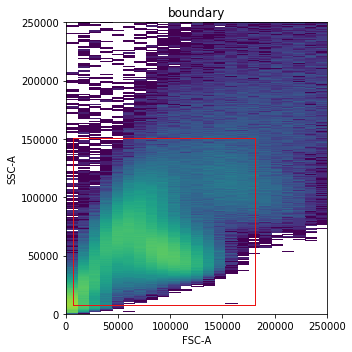

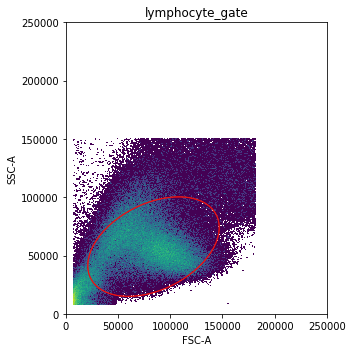

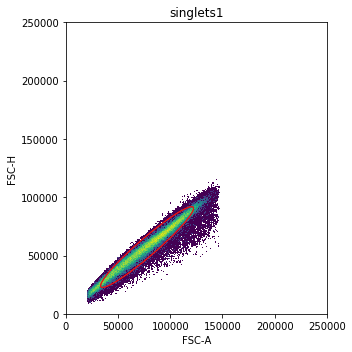

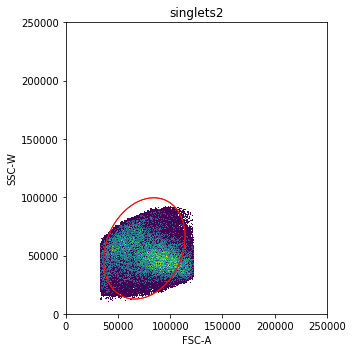

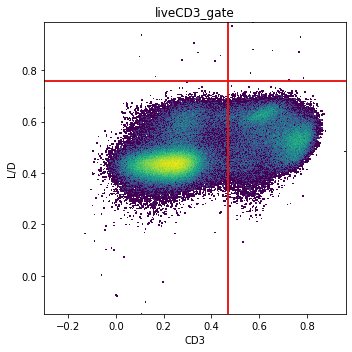

In [64]:
plot_all(sample_list[3])

In [36]:
t = Gating(texp, '209-05_pdmc_t')

In [37]:
t.remove_gate('lymphocyte_gate', propagate=True)

(['singlets1', 'singlets2', 'liveCD3_gate', 'lymphocyte_gate'],
 ['lymphocytes',
  'singlets1',
  'singlets2',
  'liveCD3',
  'dead',
  'doublets2',
  'doublets1',
  'lymphocytes',
  'other cells',
  'other cells'])

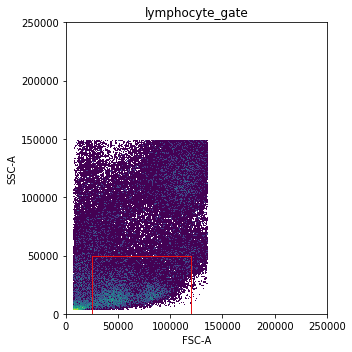

In [39]:
children = ChildPopulationCollection('geom')
children.add_population('lymphocytes', definition='+')
children.add_population('other cells', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=25000, x_max=120000, y_min=0, y_max=50000)
t.create_gate(gate_name='lymphocyte_gate', 
              parent='cells',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('lymphocyte_gate')

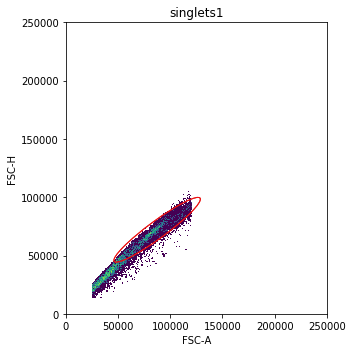

In [40]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
t.create_gate(gate_name='singlets1', 
              parent='lymphocytes',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets1')

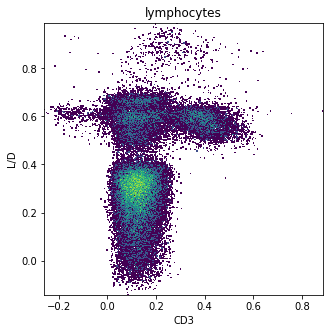

In [44]:
t.plotting.plot_population('lymphocytes', 'CD3', 'L/D', transforms={'x': 'logicle', 'y': 'logicle'})

In [45]:
len(t.populations['lymphocytes'].index)

62004

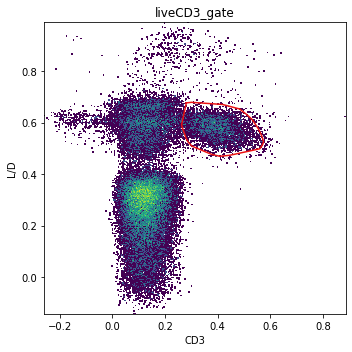

In [48]:
children = ChildPopulationCollection('cluster')
children.add_population('liveCD3', target=(0.5, 0.6), weight=1)
kwargs = dict(x='CD3', y='L/D', min_pop_size=40, frac=0.75, downsample_method='density')
t.create_gate(gate_name='liveCD3_gate', 
              parent='lymphocytes',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
t.apply('liveCD3_gate')

In [49]:
t.save(overwrite=True)

Saved successfully!


True

--------------- 210-14_pdmc_t ---------------


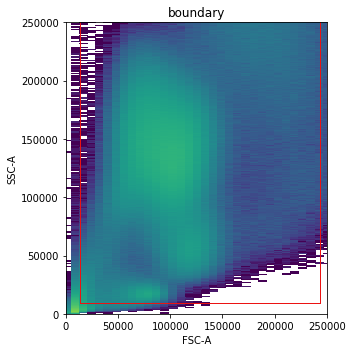

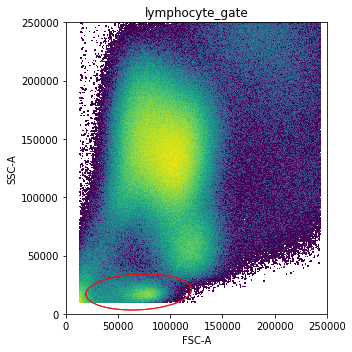

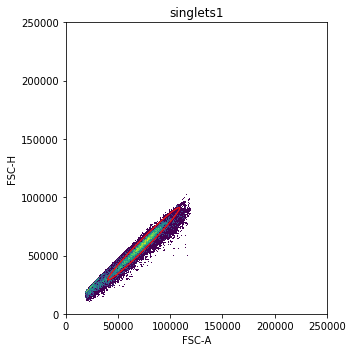

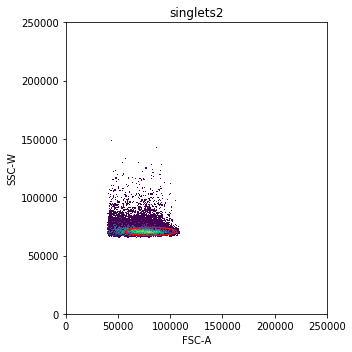

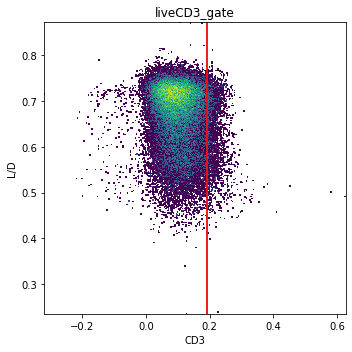

In [66]:
plot_all(sample_list[5])

Checking the original FACs analysis, CD3 stain failed in the whole panel therefore invalidating this sample for high dimensional analysis.


**Remove 210-14_pdmc_t from analysis**

In [67]:
fg = texp.pull_sample(sample_list[5])

In [68]:
fg.flags = 'invalid'
fg.notes = 'CD3 stain failed in whole panel'
fg.save()

<FileGroup: FileGroup object>

--------------- 239-02_pdmc_t ---------------


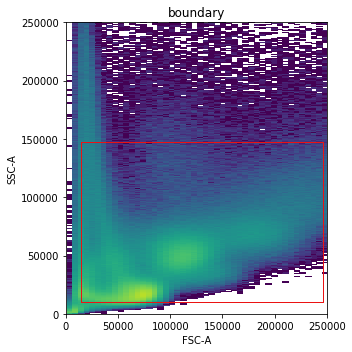

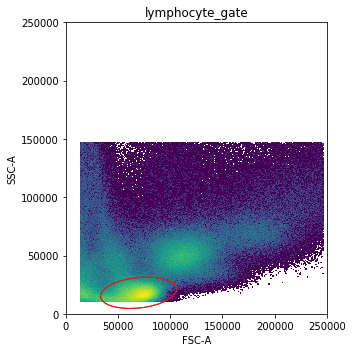

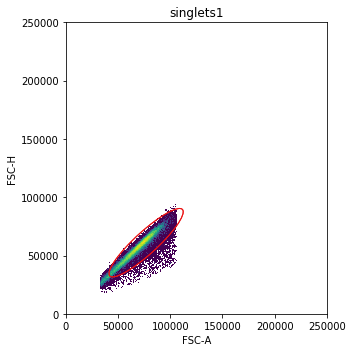

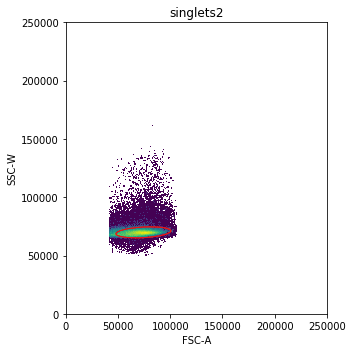

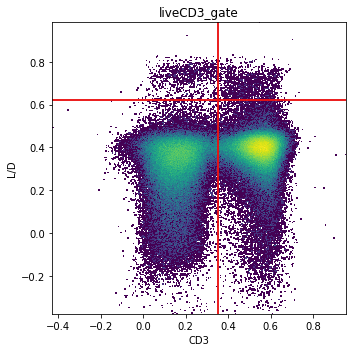

In [69]:
plot_all(sample_list[6])

--------------- 239-04_pdmc_t ---------------


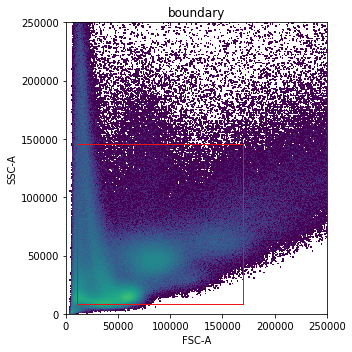

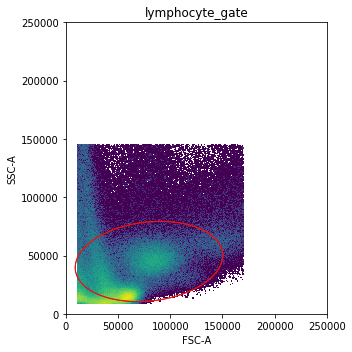

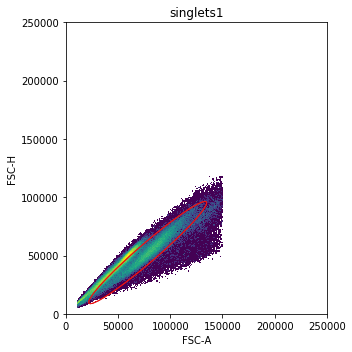

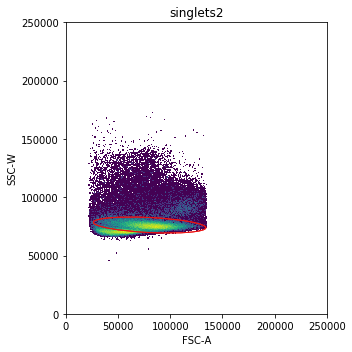

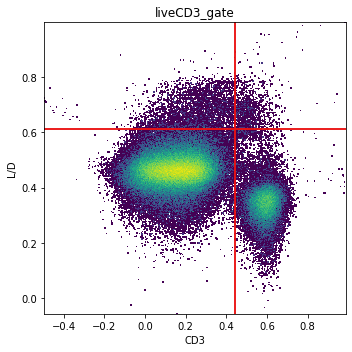

In [70]:
plot_all(sample_list[7])

--------------- 251-07_pdmc_t ---------------


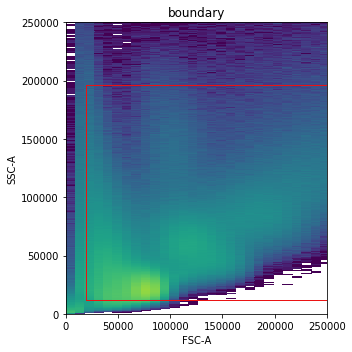

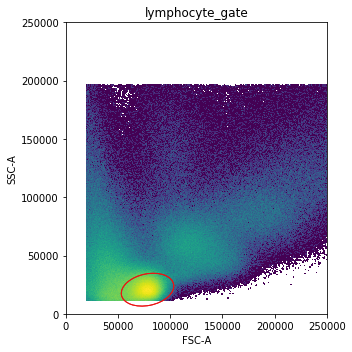

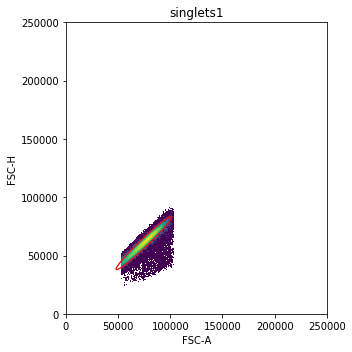

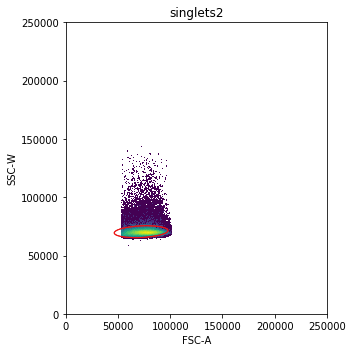

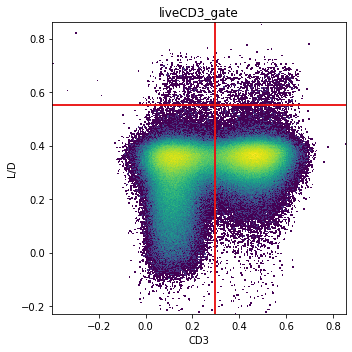

In [71]:
plot_all(sample_list[8])

--------------- 251-08_pdmc_t ---------------


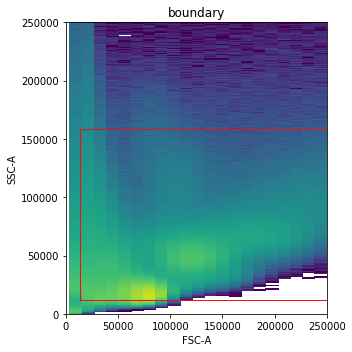

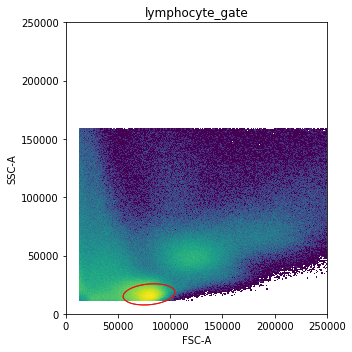

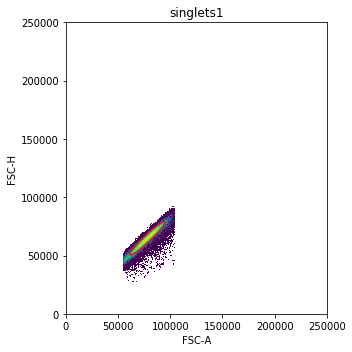

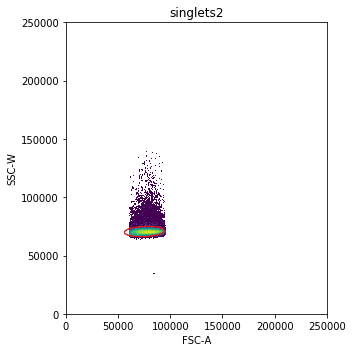

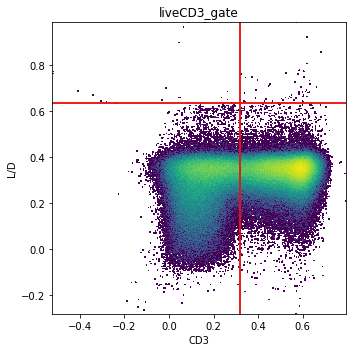

In [72]:
plot_all(sample_list[9])

--------------- 254-04_pdmc_t ---------------


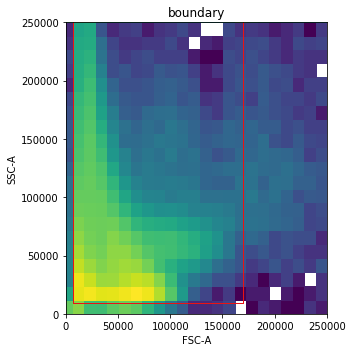

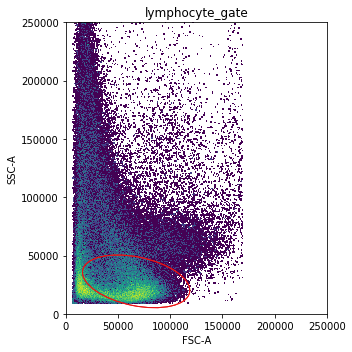

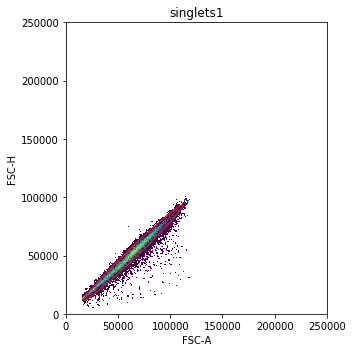

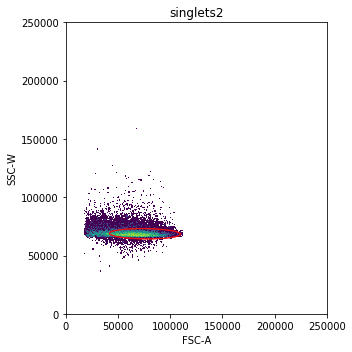

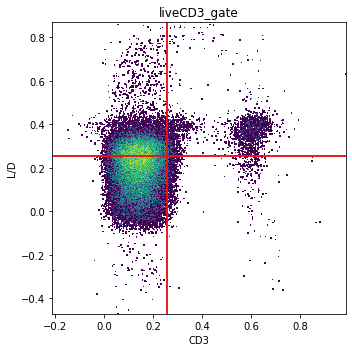

In [74]:
plot_all(sample_list[10])

In [75]:
t = Gating(texp, '254-04_pdmc_t')

In [76]:
t.remove_gate('liveCD3_gate', propagate=True)

(['liveCD3_gate'], ['liveCD3', 'liveCD3', 'dead', 'dead'])

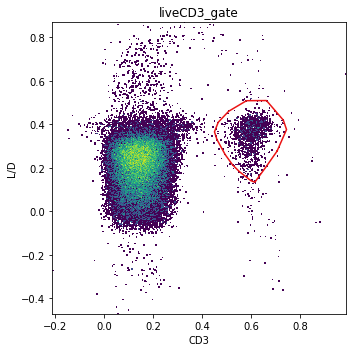

In [77]:
children = ChildPopulationCollection('cluster')
children.add_population('liveCD3', target=(0.8, 0.6), weight=1)
kwargs = dict(x='CD3', y='L/D', min_pop_size=30, frac=0.7, downsample_method='density')
t.create_gate(gate_name='liveCD3_gate', 
              parent='singlets2',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
t.apply('liveCD3_gate')

In [78]:
t.save(overwrite=True)

Saved successfully!


True

--------------- 254-05_pdmc_t ---------------


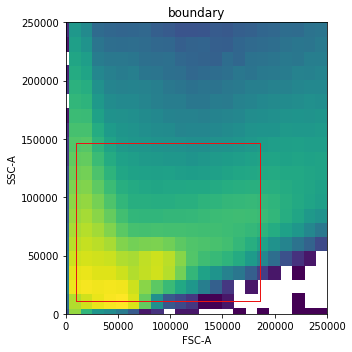

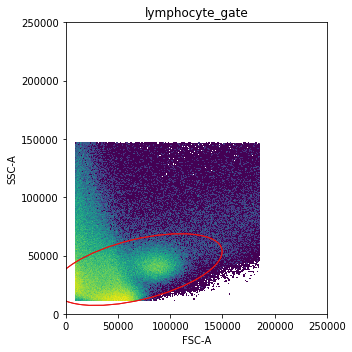

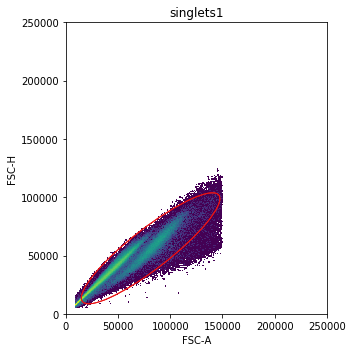

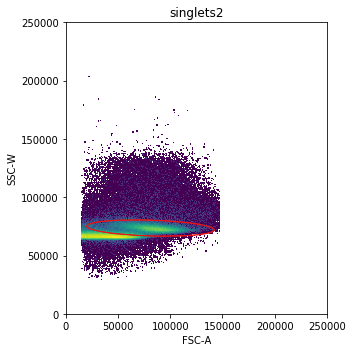

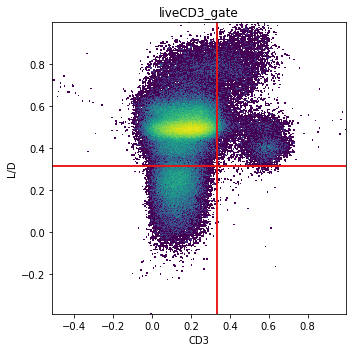

In [79]:
plot_all(sample_list[11])

In [80]:
t = Gating(texp, '254-05_pdmc_t')

In [81]:
t.remove_gate('liveCD3_gate', propagate=True)

(['liveCD3_gate'], ['liveCD3', 'liveCD3', 'dead', 'dead'])

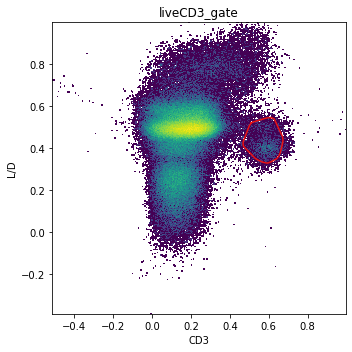

In [86]:
children = ChildPopulationCollection('cluster')
children.add_population('liveCD3', target=(0.6, 0.5), weight=1)
kwargs = dict(x='CD3', y='L/D', min_pop_size=100, frac=0.3, downsample_method='density')
t.create_gate(gate_name='liveCD3_gate', 
              parent='singlets2',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
t.apply('liveCD3_gate')

In [87]:
t.save(overwrite=True)

Saved successfully!


True

--------------- 255-04_pdmc_t ---------------


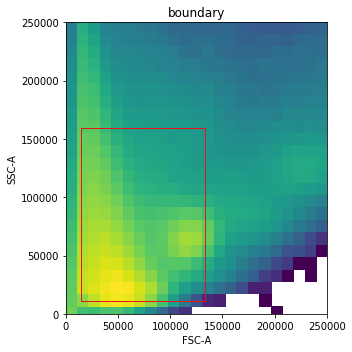

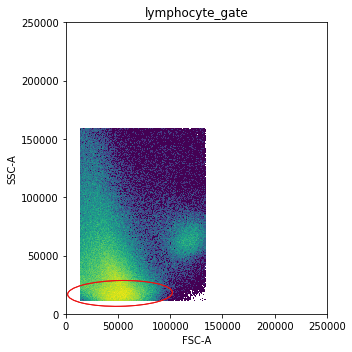

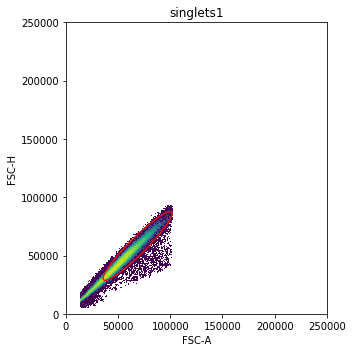

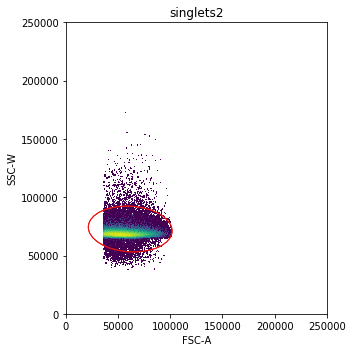

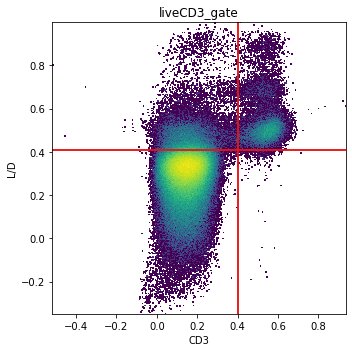

In [88]:
plot_all(sample_list[12])

In [89]:
t = Gating(texp, '255-05_pdmc_t')

In [90]:
t.remove_gate('liveCD3_gate', propagate=True)

(['liveCD3_gate'], ['liveCD3', 'liveCD3', 'dead', 'dead'])

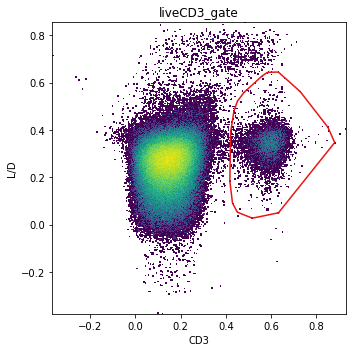

In [91]:
children = ChildPopulationCollection('cluster')
children.add_population('liveCD3', target=(0.6, 0.5), weight=1)
kwargs = dict(x='CD3', y='L/D', min_pop_size=100, frac=0.3, downsample_method='density')
t.create_gate(gate_name='liveCD3_gate', 
              parent='singlets2',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
t.apply('liveCD3_gate')

In [92]:
t.save(overwrite=True)

Saved successfully!


True

--------------- 255-05_pdmc_t ---------------


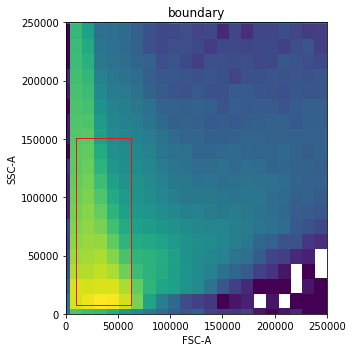

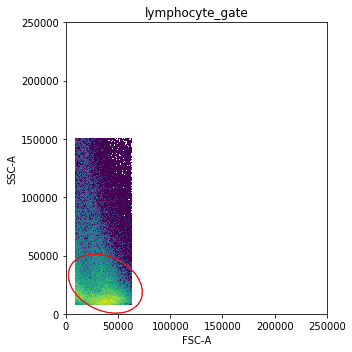

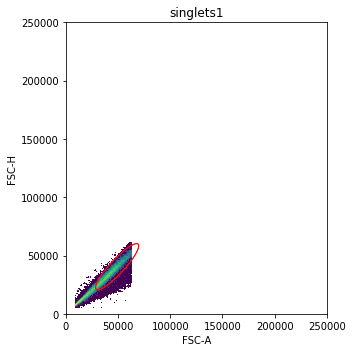

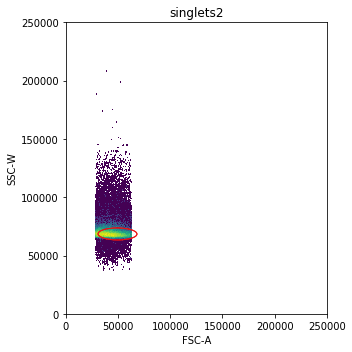

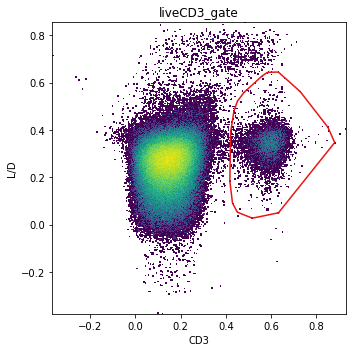

In [93]:
plot_all(sample_list[13])

--------------- 264-02_pdmc_t ---------------


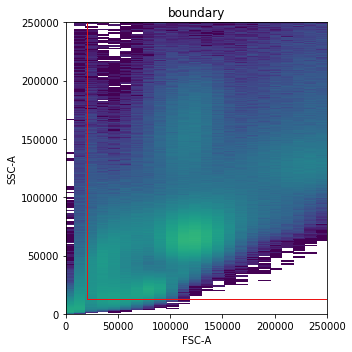

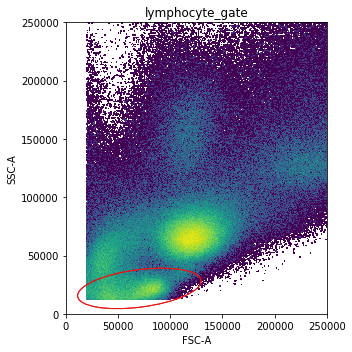

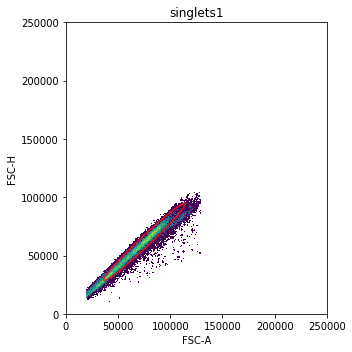

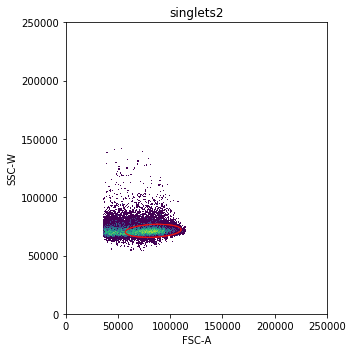

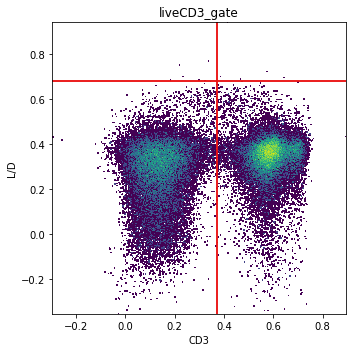

In [94]:
plot_all(sample_list[14])

--------------- 273-01_pdmc_t ---------------


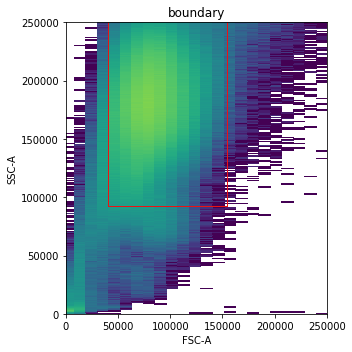

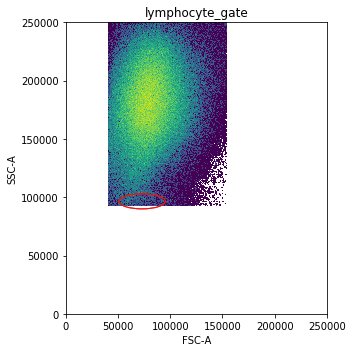

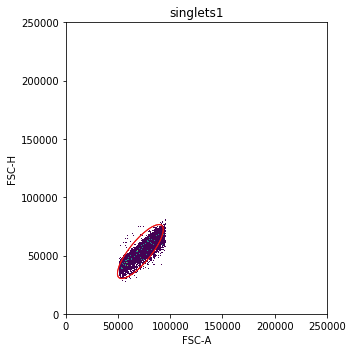

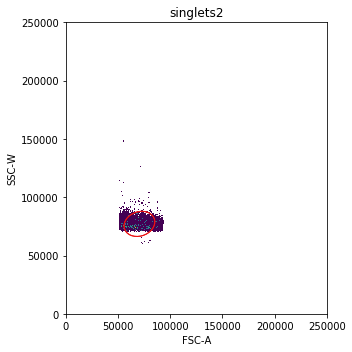

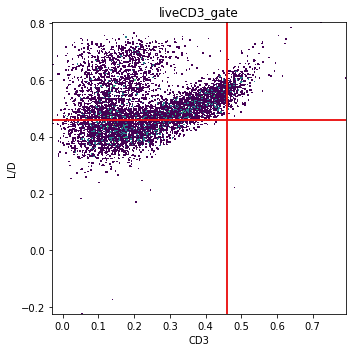

In [95]:
plot_all(sample_list[15])

In [98]:
t = Template(texp, '273-01_pdmc_t')
t.remove_gate('boundary', propagate=True)

(['lymphocyte_gate', 'singlets1', 'singlets2', 'liveCD3_gate', 'boundary'],
 ['cells',
  'lymphocytes',
  'singlets1',
  'singlets2',
  'liveCD3',
  'dead',
  'doublets2',
  'doublets1',
  'other cells',
  'cells',
  'debris',
  'debris'])

In [100]:
t.load_template('Preprocessing T Panel')

True

In [103]:
t.populations['cells'] = t.populations['root']

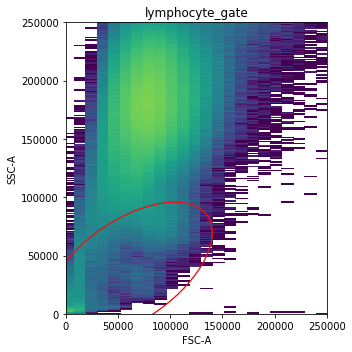

In [105]:
t.apply('lymphocyte_gate')

In [106]:
t.gates.keys()

dict_keys(['boundary', 'lymphocyte_gate', 'singlets1', 'singlets2', 'liveCD3_gate'])

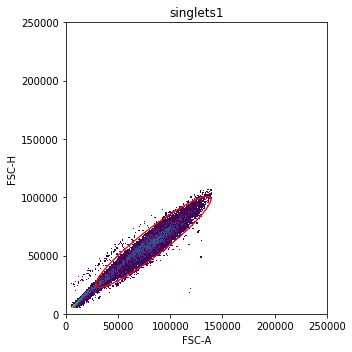

In [107]:
t.apply('singlets1')

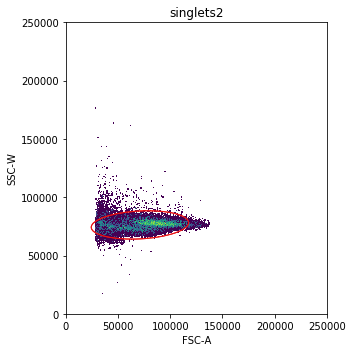

In [108]:
t.apply('singlets2')

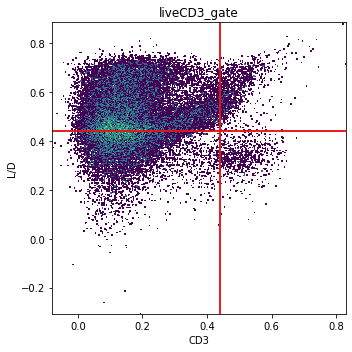

In [109]:
t.apply('liveCD3_gate')

In [115]:
t.populations['cells'].parent = t.populations['root']

LoopError: Cannot set parent. Node('/root', geom={'shape': None, 'x': 'FSC-A', 'y': 'SSC-A'}, index=array([      0,       1,       2, ..., 1889514, 1889515, 1889516]), prop_of_parent=1.0, prop_of_total=1.0, warnings=[]) cannot be parent of itself.

In [111]:
t.save(overwrite=True)

AttributeError: 'NoneType' object has no attribute 'name'

--------------- 276-01_pdmc_t ---------------


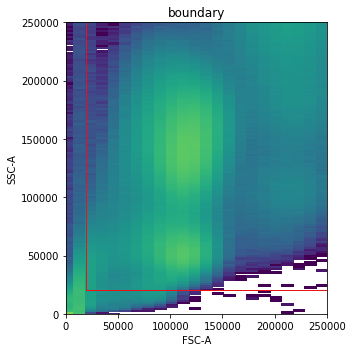

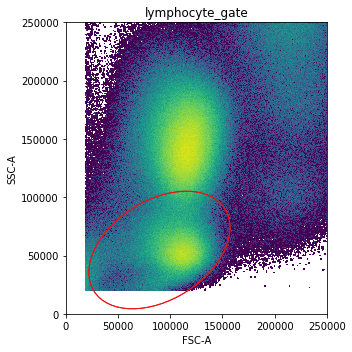

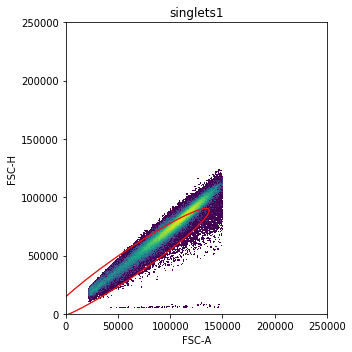

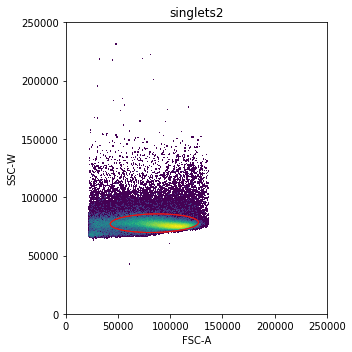

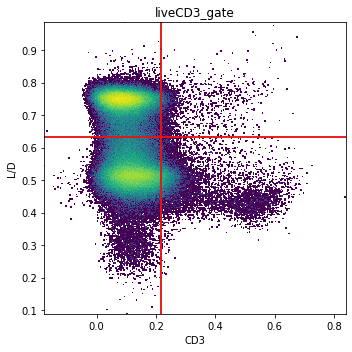

In [116]:
plot_all(sample_list[16])

--------------- 286-03_pdmc_t ---------------


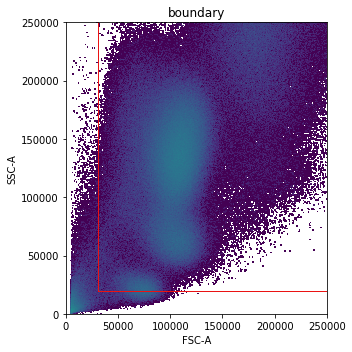

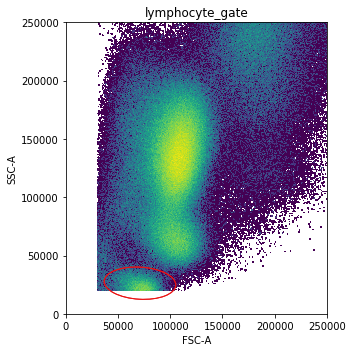

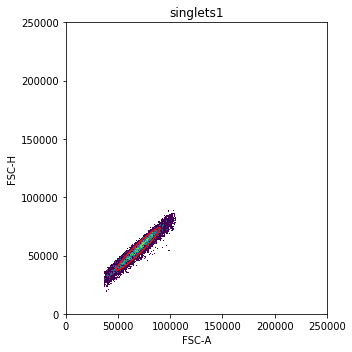

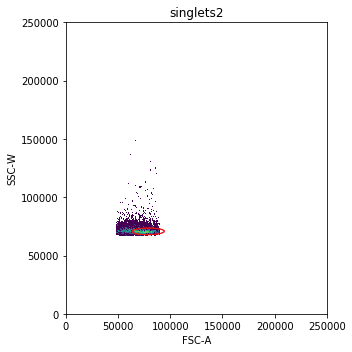

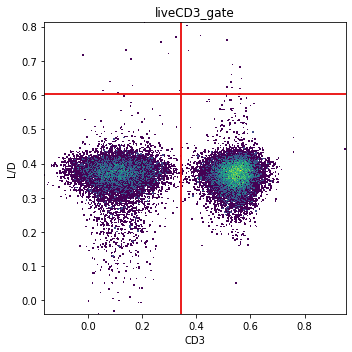

In [117]:
plot_all(sample_list[17])

--------------- 286-04_pdmc_t ---------------


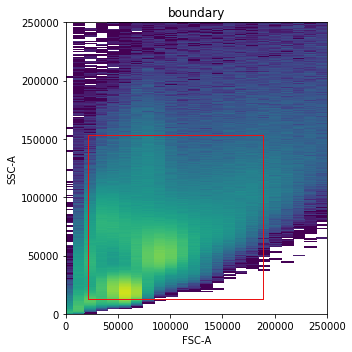

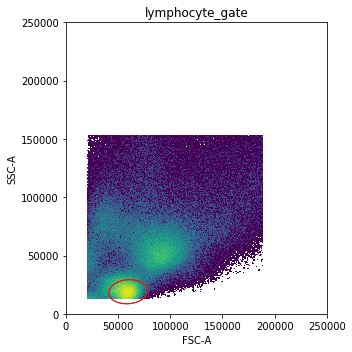

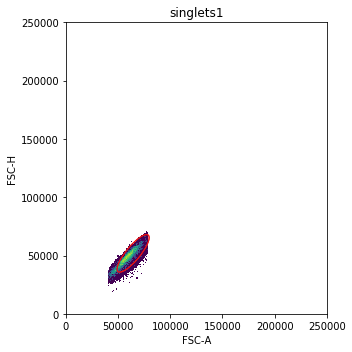

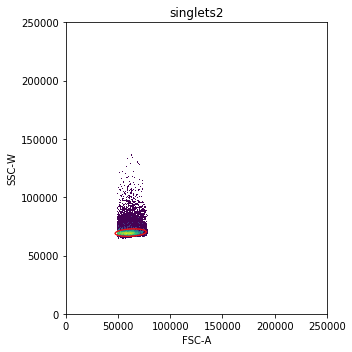

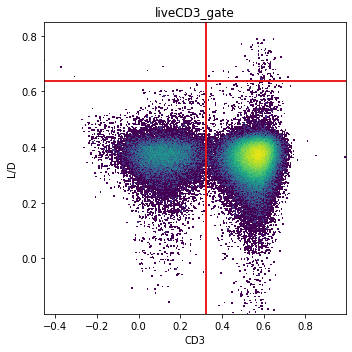

In [118]:
plot_all(sample_list[18])

--------------- 294-02_pdmc_t ---------------


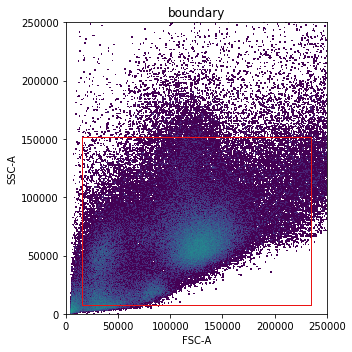

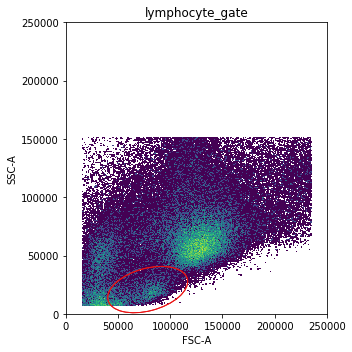

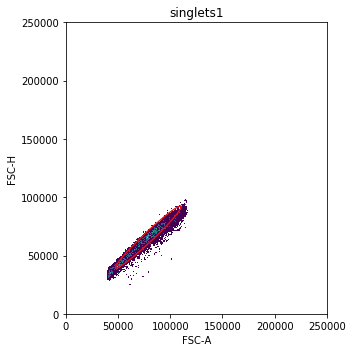

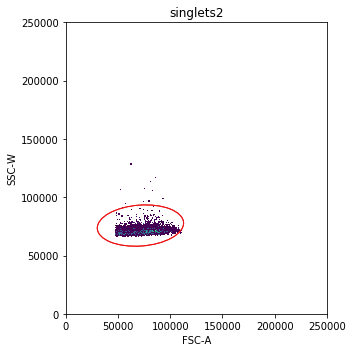

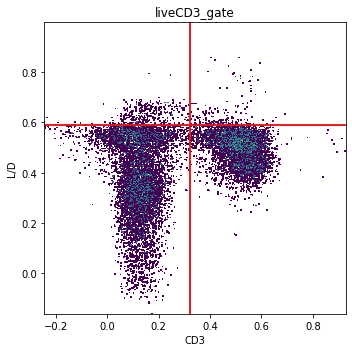

In [119]:
plot_all(sample_list[19])

--------------- 294-03_pdmc_t ---------------


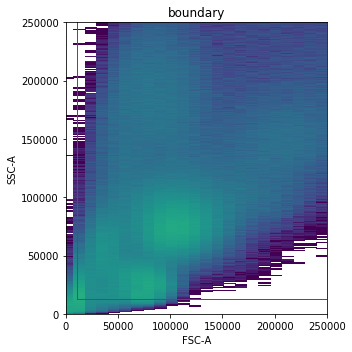

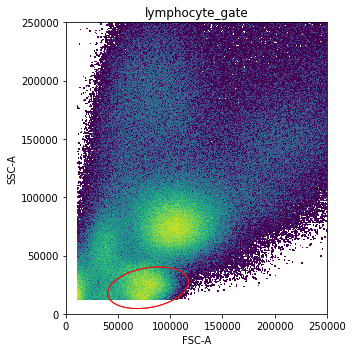

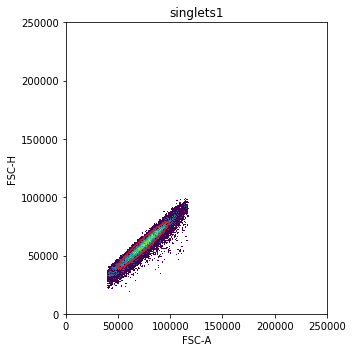

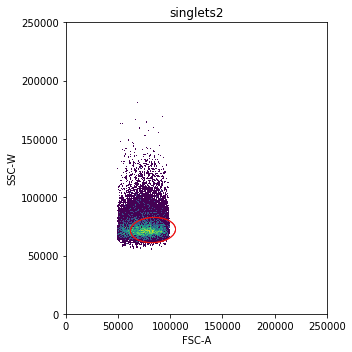

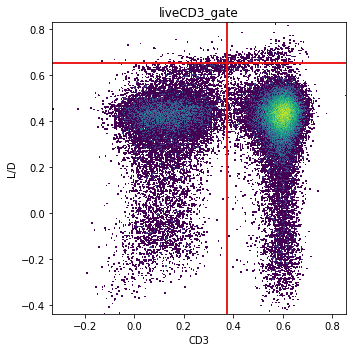

In [120]:
plot_all(sample_list[20])

--------------- 298-01_pdmc_t ---------------


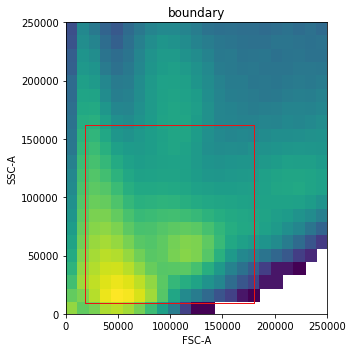

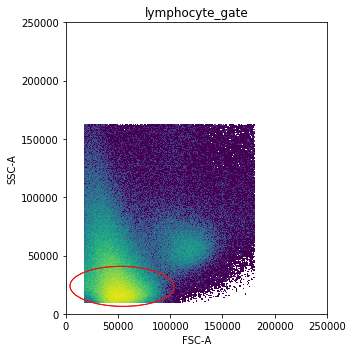

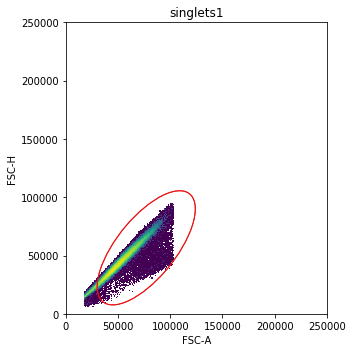

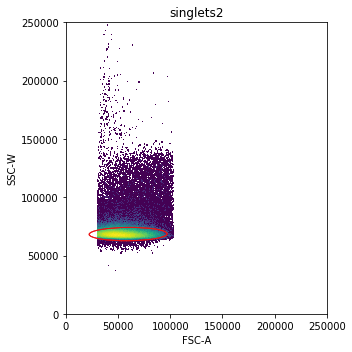

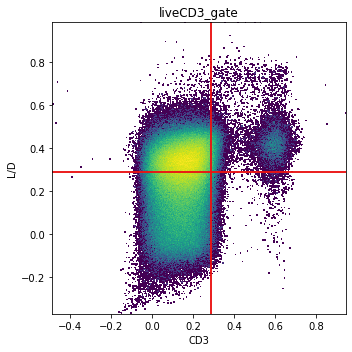

In [121]:
plot_all(sample_list[21])

--------------- 305-01_pdmc_t ---------------


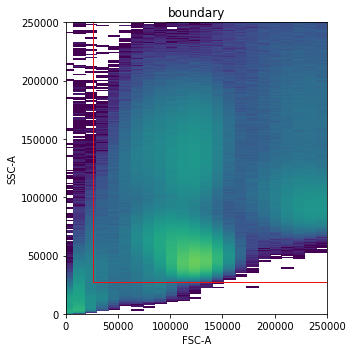

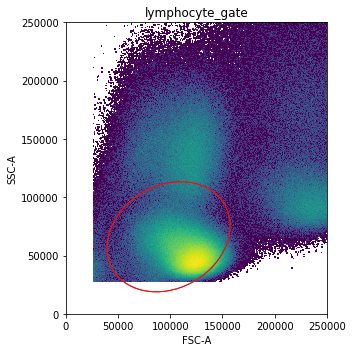

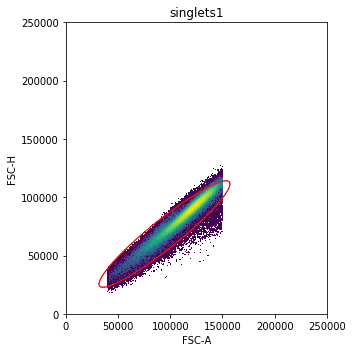

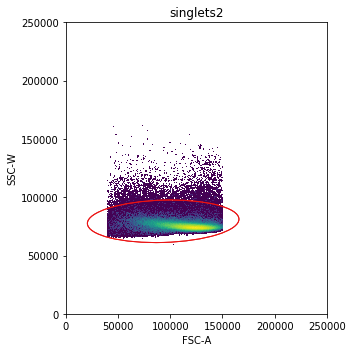

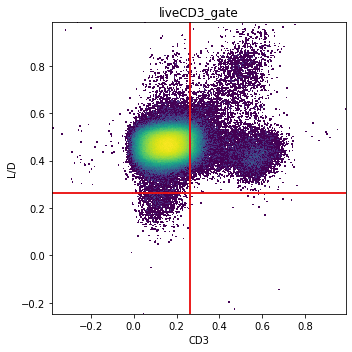

In [122]:
plot_all(sample_list[22])

--------------- 305-03_pdmc_t ---------------


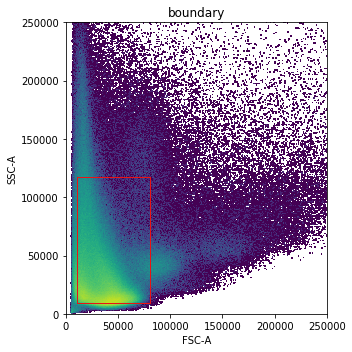

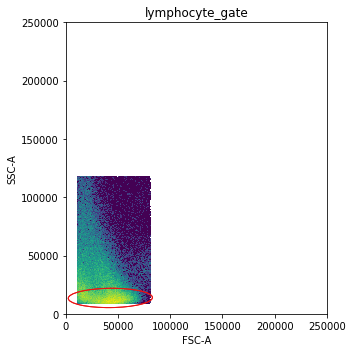

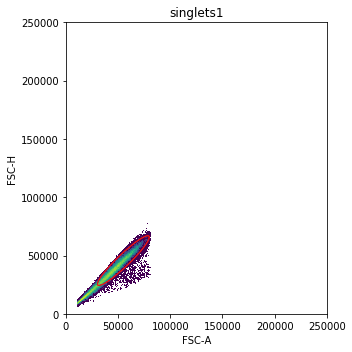

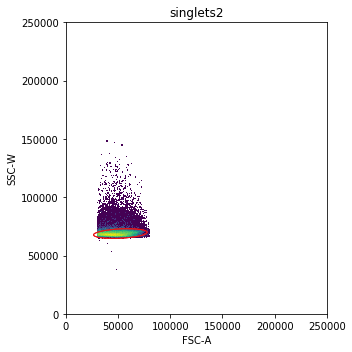

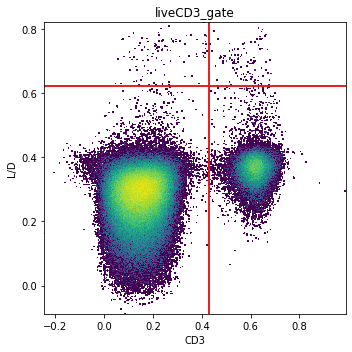

In [123]:
plot_all(sample_list[23])

--------------- 306-01_pdmc_t ---------------


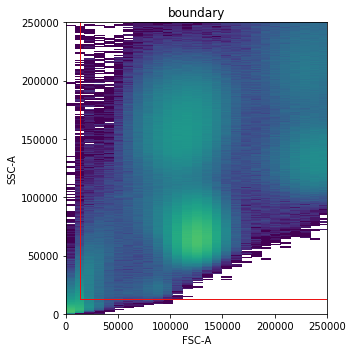

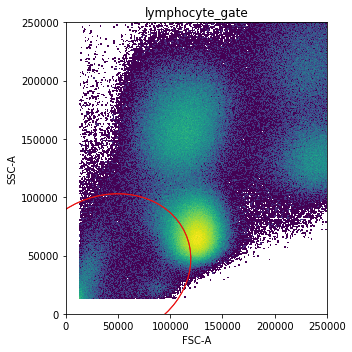

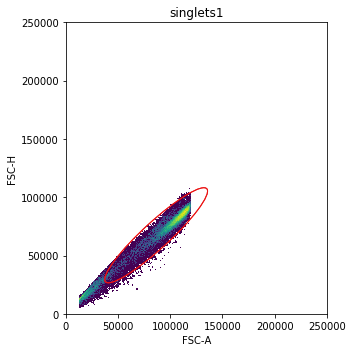

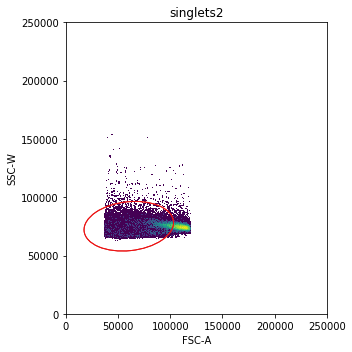

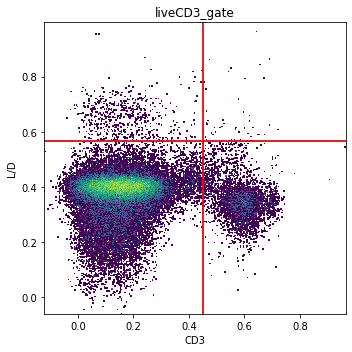

In [124]:
plot_all(sample_list[24])

--------------- 308-02R_pdmc_t ---------------


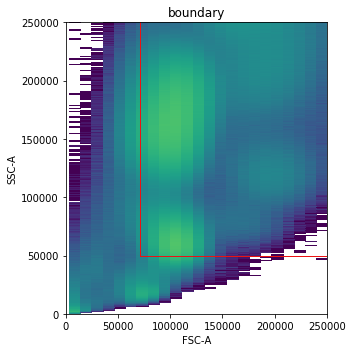

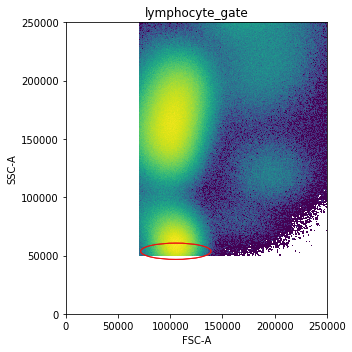

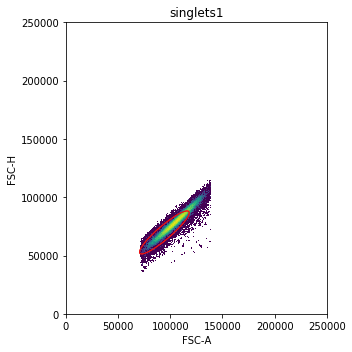

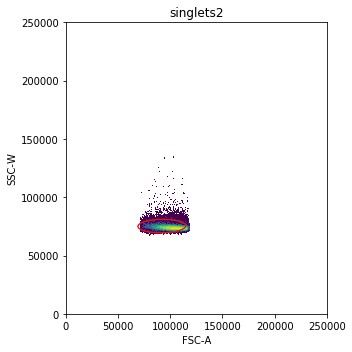

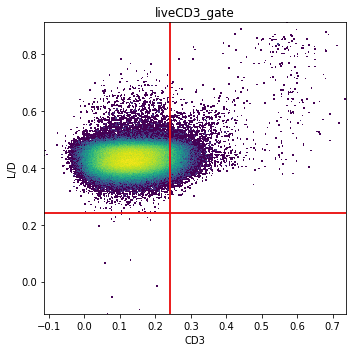

In [125]:
plot_all(sample_list[25])

--------------- 308-03R_pdmc_t ---------------


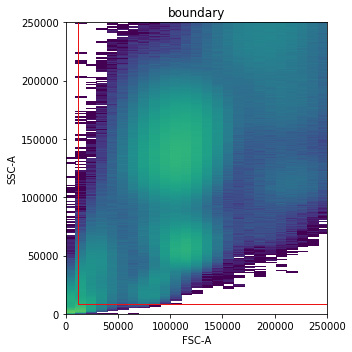

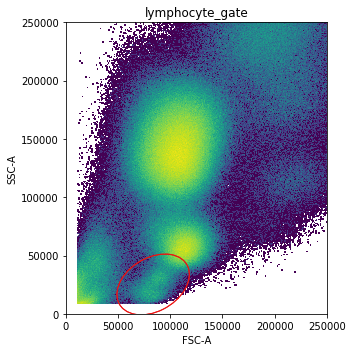

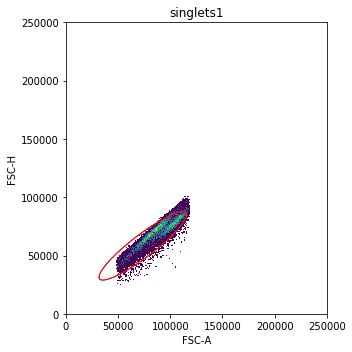

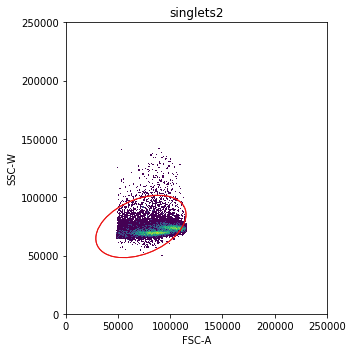

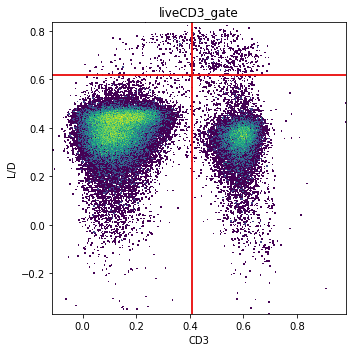

In [126]:
plot_all(sample_list[26])

--------------- 308-04_pdmc_t ---------------


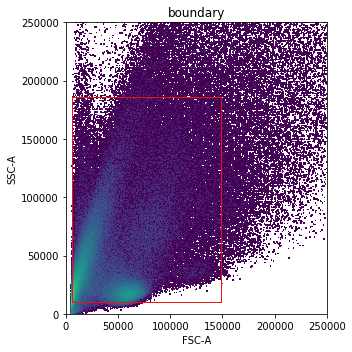

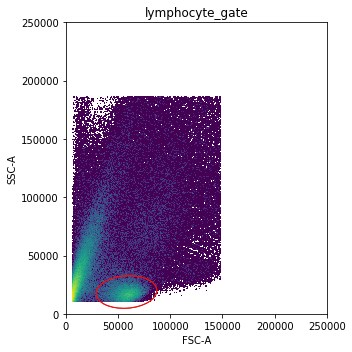

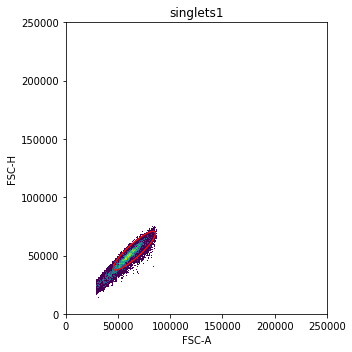

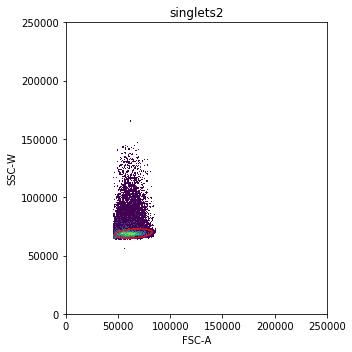

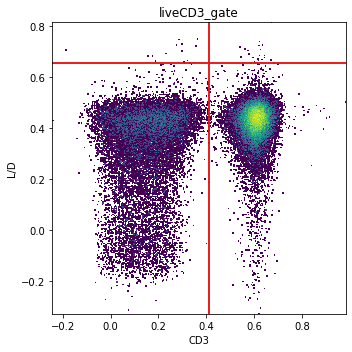

In [127]:
plot_all(sample_list[27])

--------------- 310-01_pdmc_t ---------------


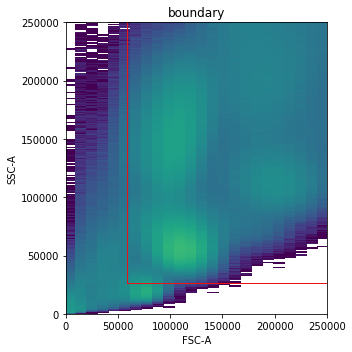

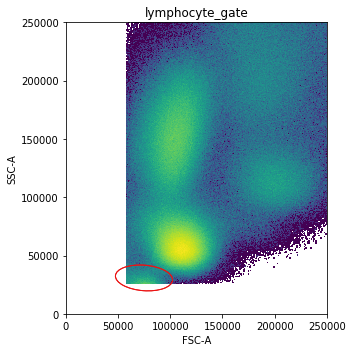

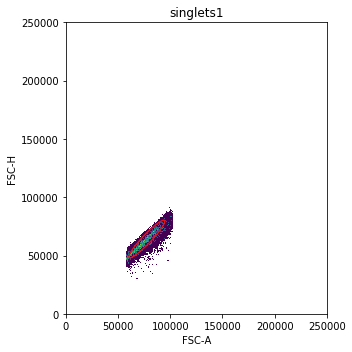

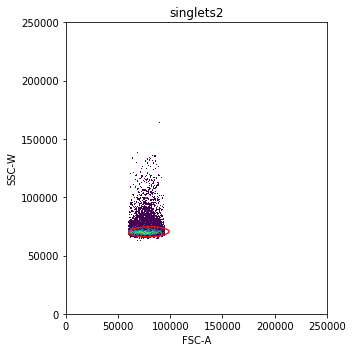

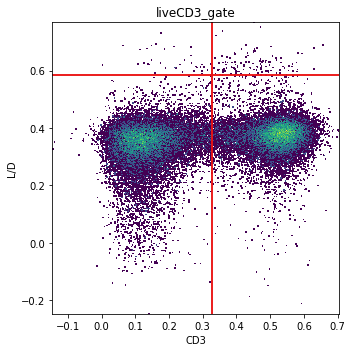

In [128]:
plot_all(sample_list[28])

--------------- 315-01_pdmc_t ---------------


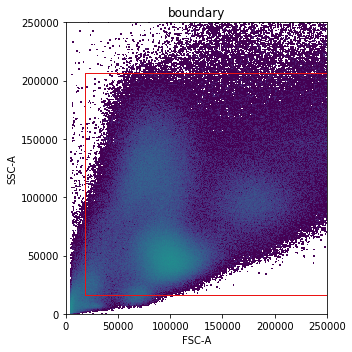

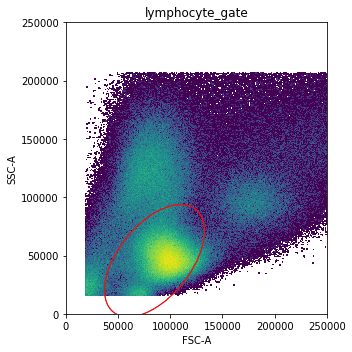

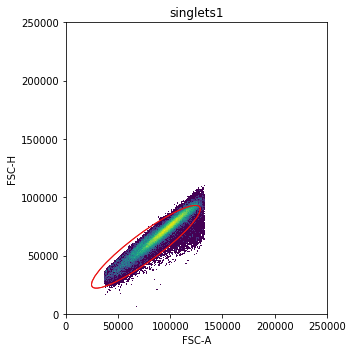

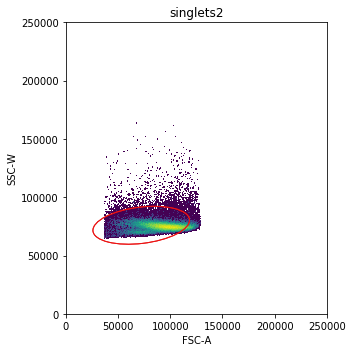

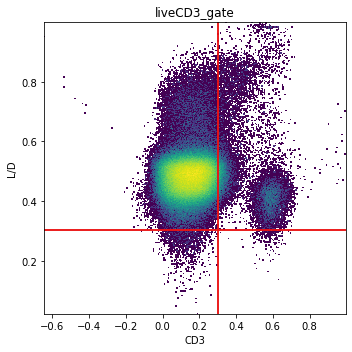

In [129]:
plot_all(sample_list[29])

--------------- 315-02_pdmc_t ---------------


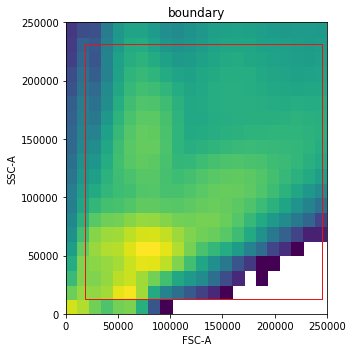

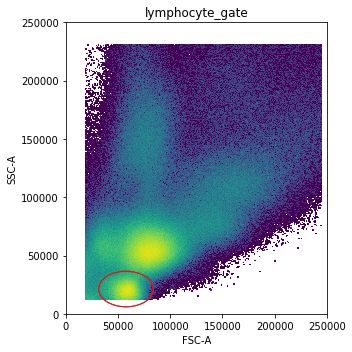

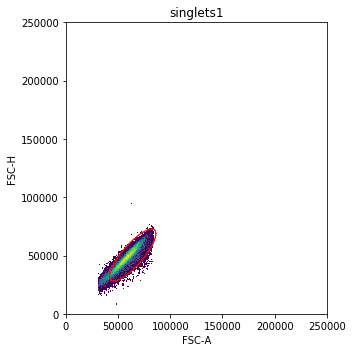

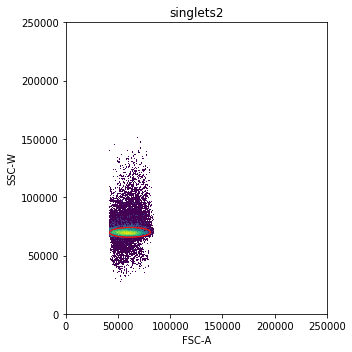

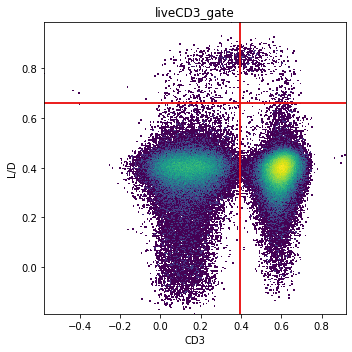

In [130]:
plot_all(sample_list[30])

--------------- 318-01_pdmc_t ---------------


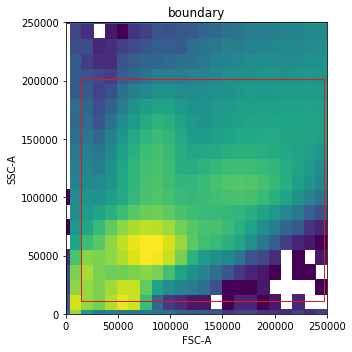

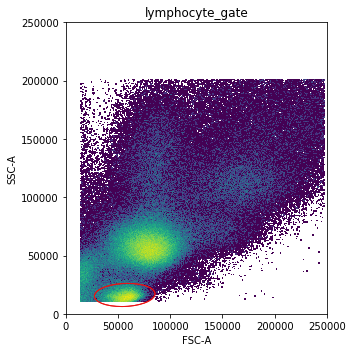

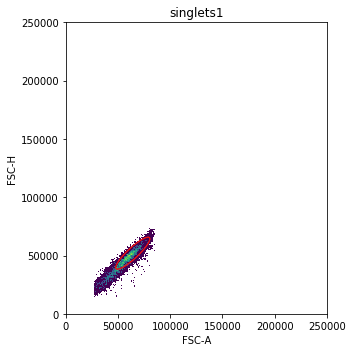

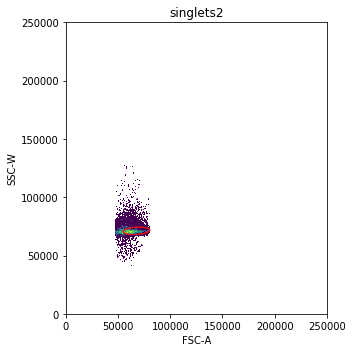

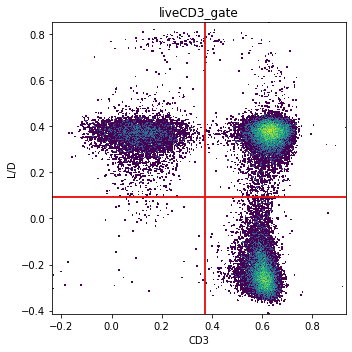

In [131]:
plot_all(sample_list[31])

--------------- 322-01_pdmc_t ---------------


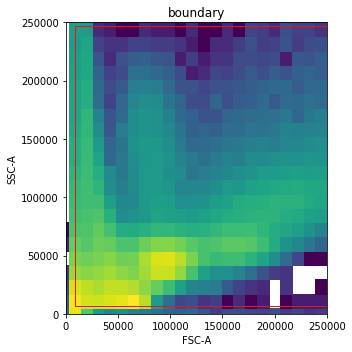

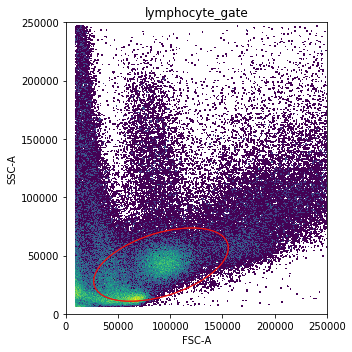

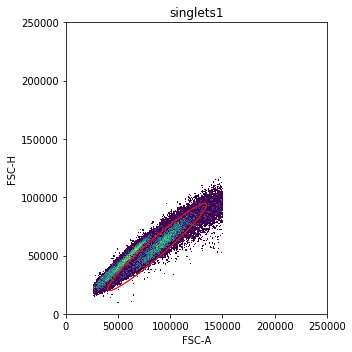

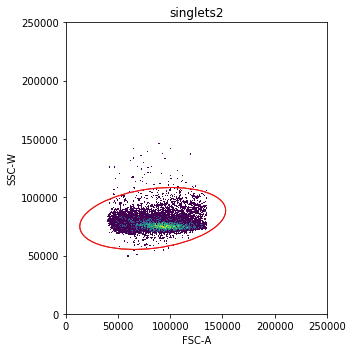

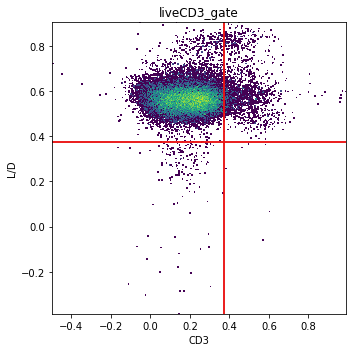

In [132]:
plot_all(sample_list[32])

--------------- 323-01_pdmc_t ---------------


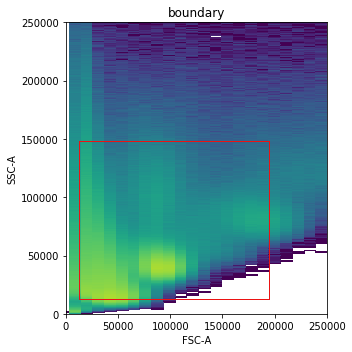

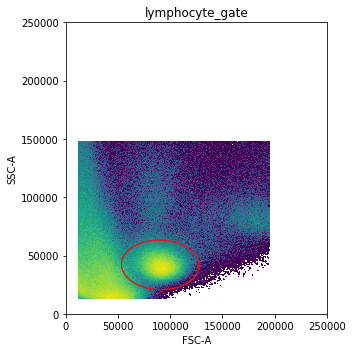

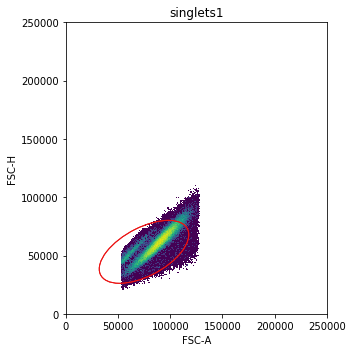

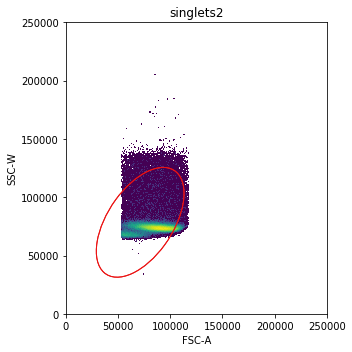

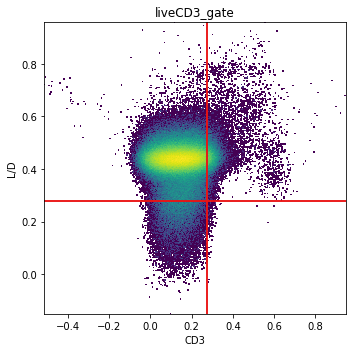

In [133]:
plot_all(sample_list[33])

--------------- 324-01_pdmc_t ---------------


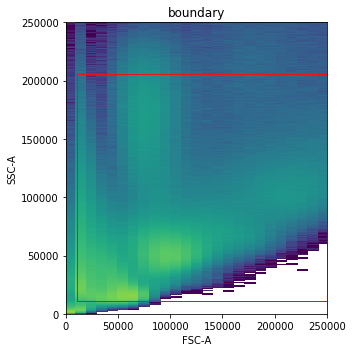

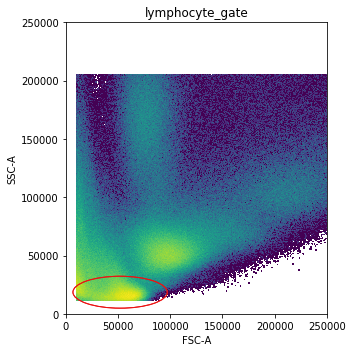

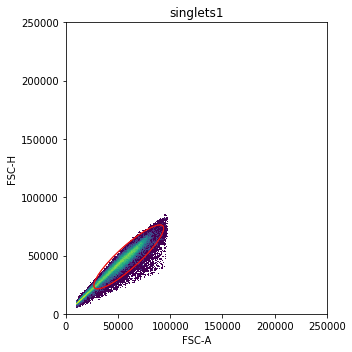

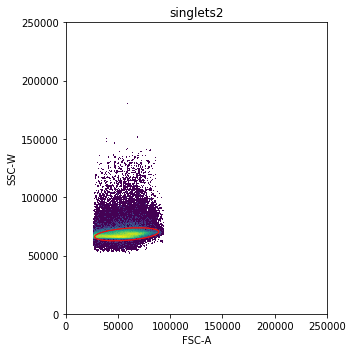

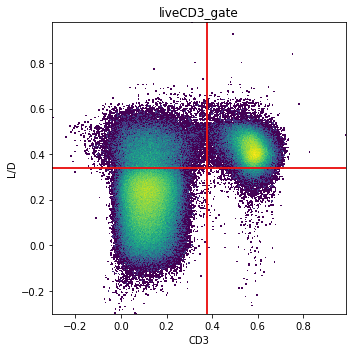

In [134]:
plot_all(sample_list[34])

--------------- 326-01_pdmc_t ---------------


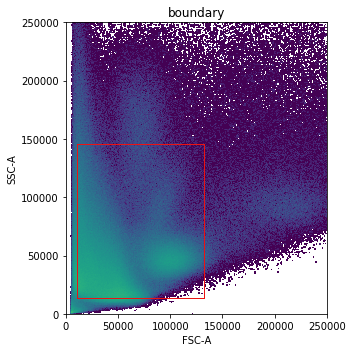

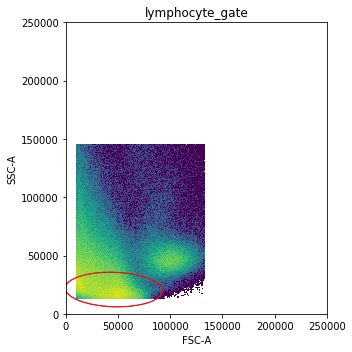

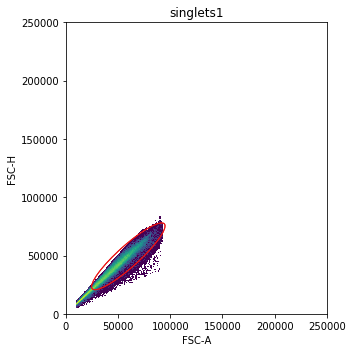

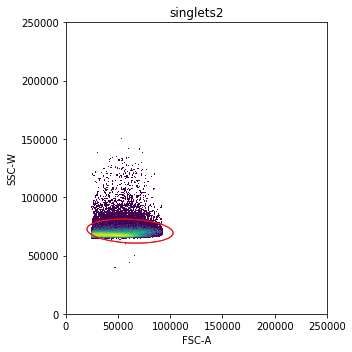

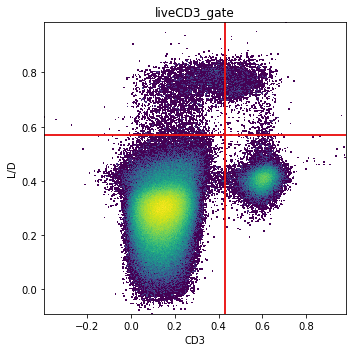

In [135]:
plot_all(sample_list[35])

--------------- 237-06_pdmc_t ---------------


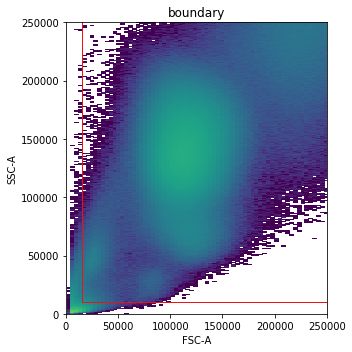

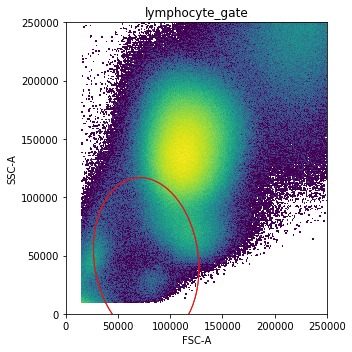

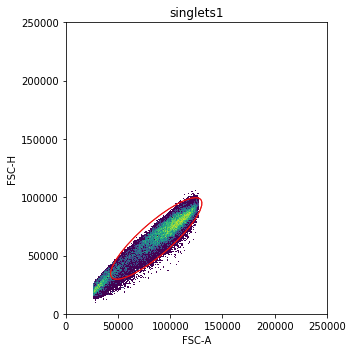

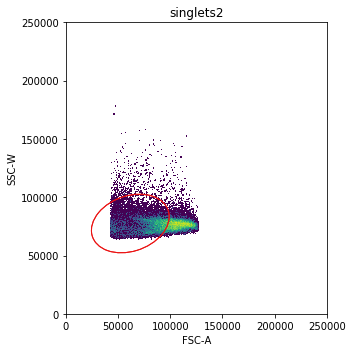

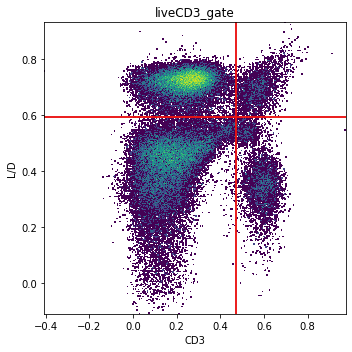

In [136]:
plot_all(sample_list[36])

--------------- 267-01_pdmc_t ---------------


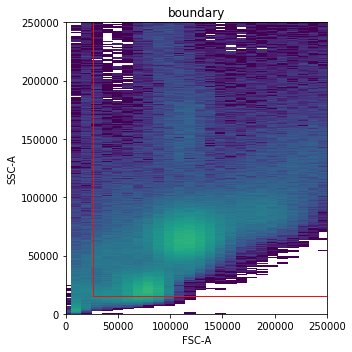

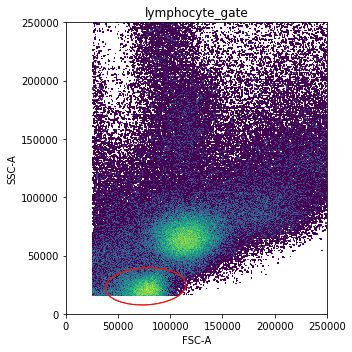

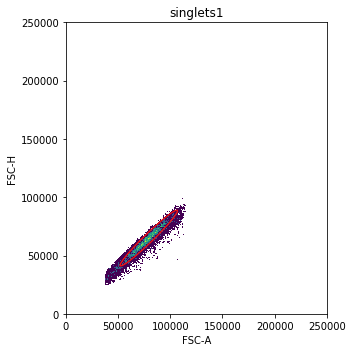

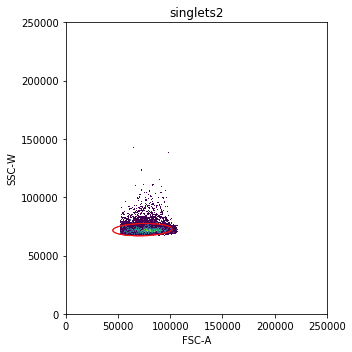

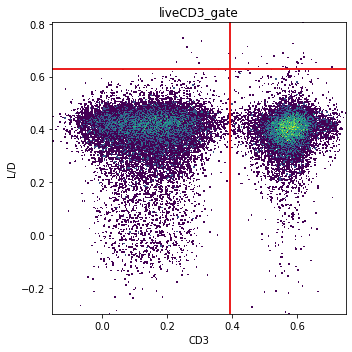

In [137]:
plot_all(sample_list[37])

--------------- 279-03_pdmc_t ---------------


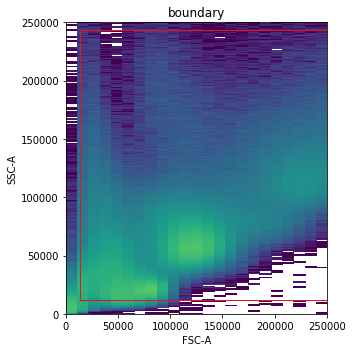

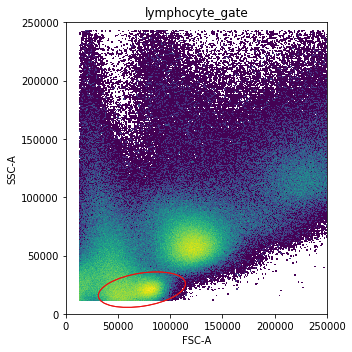

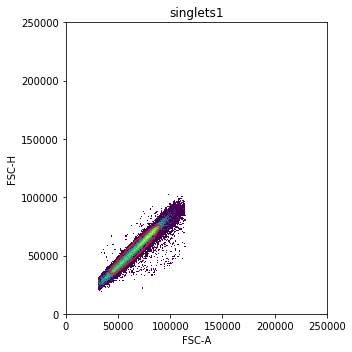

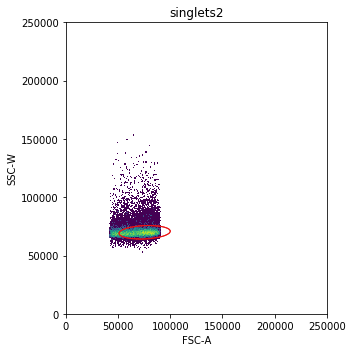

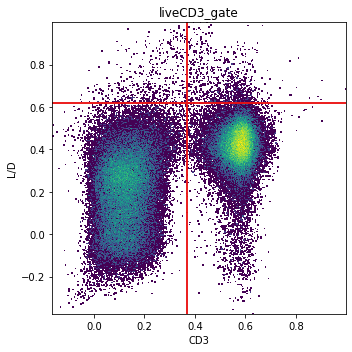

In [138]:
plot_all(sample_list[38])

--------------- 286-02_pdmc_t ---------------


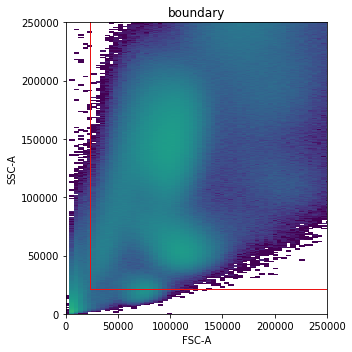

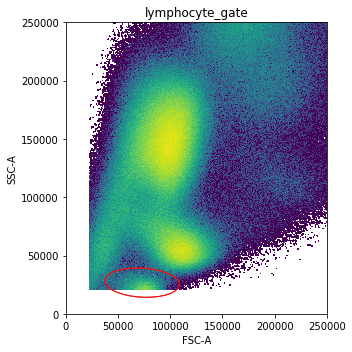

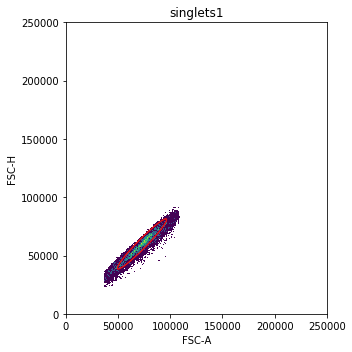

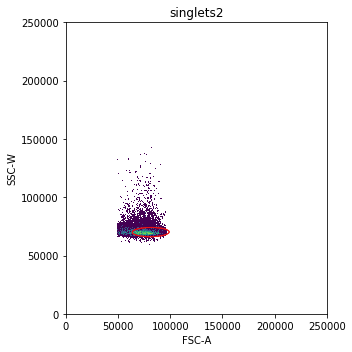

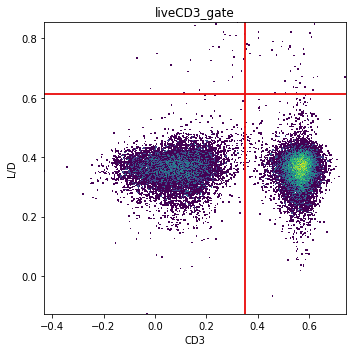

In [139]:
plot_all(sample_list[39])

--------------- 288-02_pdmc_t ---------------


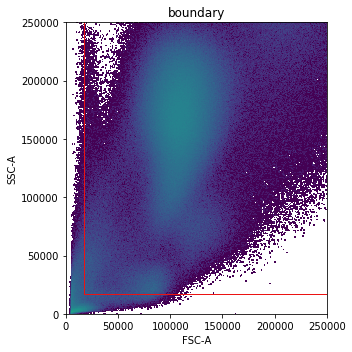

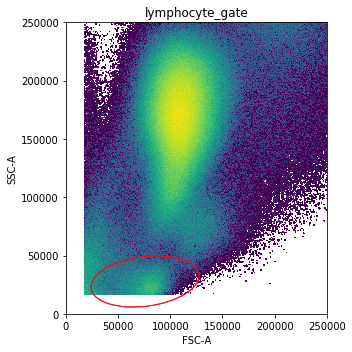

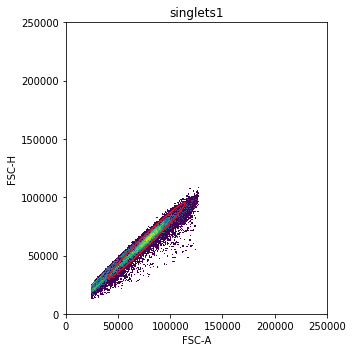

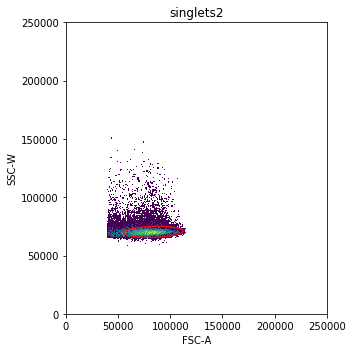

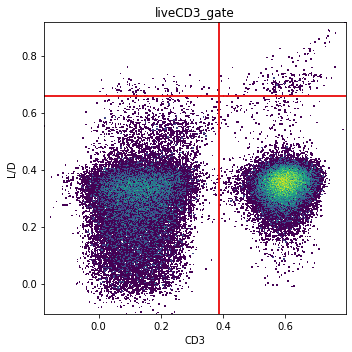

In [140]:
plot_all(sample_list[40])

--------------- 294-01_pdmc_t ---------------


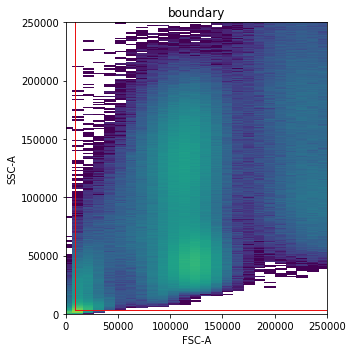

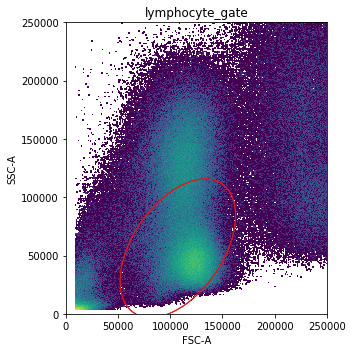

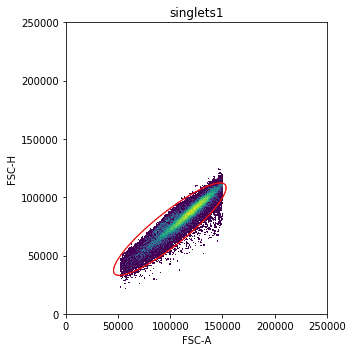

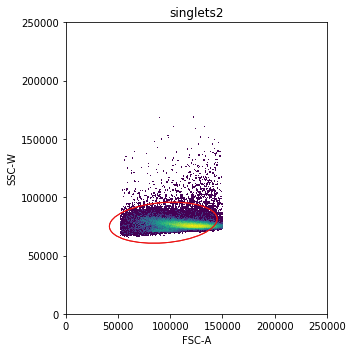

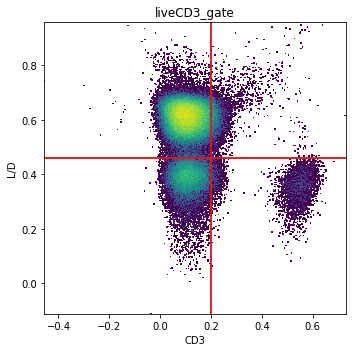

In [141]:
plot_all(sample_list[41])

--------------- 302-01_pdmc_t ---------------


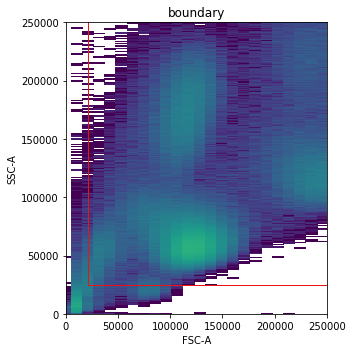

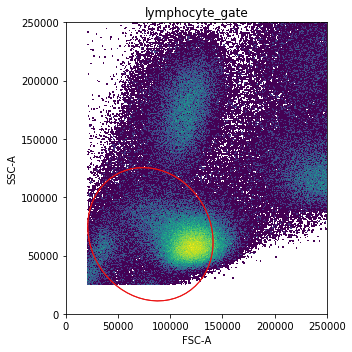

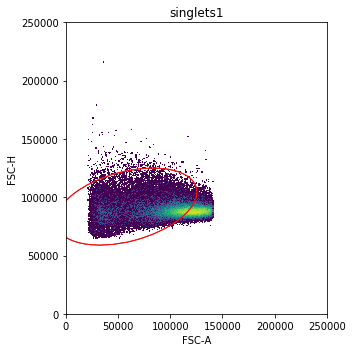

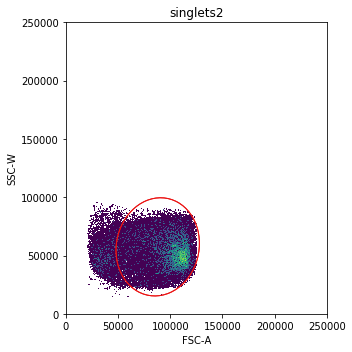

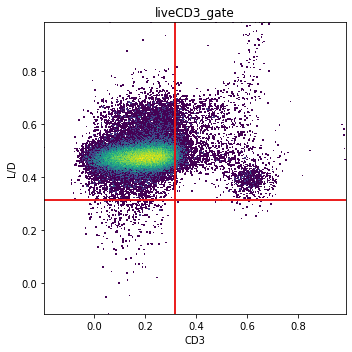

In [142]:
plot_all(sample_list[42])

--------------- 307-01_pdmc_t ---------------


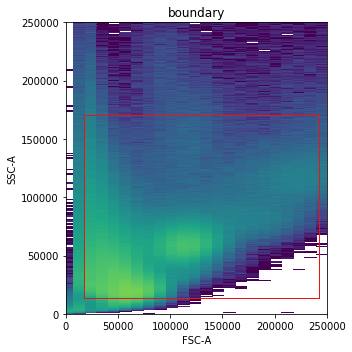

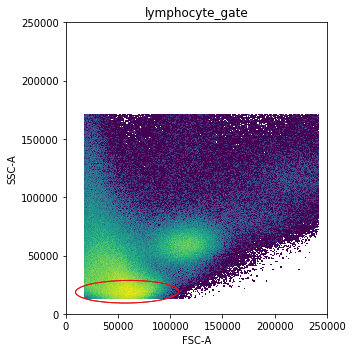

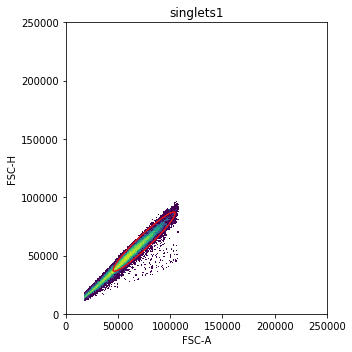

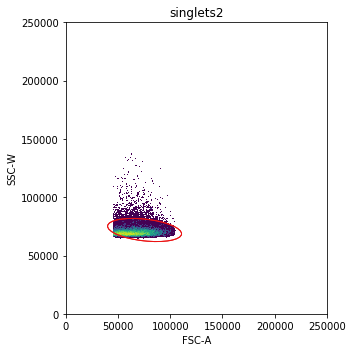

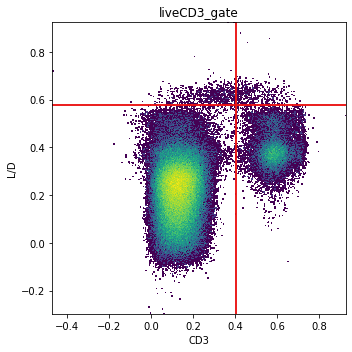

In [143]:
plot_all(sample_list[43])